# Test Bioceanor - Benjamin Goehry

## Objectif : construire un modèle de prédiction pour l'oxygène dissous

 A partir de slots de 2 jours (48 points), prédire les 6 heures suivantes (6 points).
 
 ### Importation des librairies

In [4]:
##chargement des librairies
from collections import deque 
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
from itertools import groupby
import matplotlib.pyplot as plt
import seaborn as sns
import datetime #pour calculer la durée des méthodes
import math
from statistics import mean
from statistics import stdev
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### Importation des données

In [2]:
##import des données
data_raw = pd.read_csv('data_for_interview.csv')
n = len(data_raw.index) #nombre de lignes
p = len(data_raw.columns) #nombre de colonnes
print("Nombre d'observations : ", n)
print("Nombre de variables : ", p)
data = data_raw.copy(deep=True)
data_raw.head()

Nombre d'observations :  1099
Nombre de variables :  11


,Unnamed: 0,Datetime,WaterTemperature,DissolvedOxygen,device,site,weather_temperature,dewpoint,humidity,windspeed,winddirection
0,0,2020-06-15 09:00:00,22.810,98.200,device 1,site A,23.2,11.9,49,41.0,300
1,1,2020-06-15 11:00:00,22.910,98.460,device 1,site A,26.0,12.1,42,38.9,309
2,2,2020-06-15 12:00:00,22.910,NaN,device 1,site A,26.1,11.4,40,37.0,310
3,3,2020-06-15 14:00:00,23.365,101.585,device 1,site A,27.0,9.8,34,37.0,307
4,4,2020-06-15 16:00:00,23.470,NaN,device 1,site A,27.0,9.8,34,33.3,308


## Analyse exploratoire

Nous avons un total de 1099 observations et 10 variables (en enlevant la variable 'Unnamed : 0'). On observe rapidement qu'il existe des valeurs manquantes pour l'oxygène dissous. Vérifions qu'il y en ait pas d'autres.

In [3]:
columns_names = list(data.columns)
print(columns_names)
print(data.dtypes)
for name in columns_names:
    # creating bool series True for NaN values  
    bool_series = pd.isnull(data_raw[name])  
    # filtering data  
    # displaying data only with name = NaN 
    print(name)
    print(data_raw[bool_series]) 


['Unnamed: 0', 'Datetime', 'WaterTemperature', 'DissolvedOxygen', 'device', 'site', 'weather_temperature', 'dewpoint', 'humidity', 'windspeed', 'winddirection']
Unnamed: 0               int64
Datetime                object
WaterTemperature       float64
DissolvedOxygen        float64
device                  object
site                    object
weather_temperature    float64
dewpoint               float64
humidity                 int64
windspeed              float64
winddirection            int64
dtype: object
Unnamed: 0
Empty DataFrame
Columns: [Unnamed: 0, Datetime, WaterTemperature, DissolvedOxygen, device, site, weather_temperature, dewpoint, humidity, windspeed, winddirection]
Index: []
Datetime
Empty DataFrame
Columns: [Unnamed: 0, Datetime, WaterTemperature, DissolvedOxygen, device, site, weather_temperature, dewpoint, humidity, windspeed, winddirection]
Index: []
WaterTemperature
Empty DataFrame
Columns: [Unnamed: 0, Datetime, WaterTemperature, DissolvedOxygen, device, site, we

Seules trois valeurs sont manquantes et ceci pour la variable DissolvedOxygen venant du Device 1. Nous remarquons également très rapidement que les données ne sont pas dans l'ordre chronologique et que le nombre d'observations sont du même ordre de grandeur pour les 5 appareils. Il sera aussi utile d'ajouter une variable correspond à l'heure pour pousser l'analyse plus en détails.

In [4]:
data['Datetime'] = pd.to_datetime(data['Datetime'])
data['hour'] = data['Datetime'].dt.hour
#print(data)

### Description (moyenne + écart-type) des variables conditionnellement à l'heure

In [5]:
data.describe()

print("Moyenne par heure pour les variables continues:")
print(data.groupby(['hour']).mean())
print("Ecart type par heure pour les variables continues:")
print(data.groupby(['hour']).std())

Moyenne par heure pour les variables continues:
      Unnamed: 0  WaterTemperature  DissolvedOxygen  weather_temperature  \
hour                                                                       
0     544.333333         18.398185        89.084407            18.404444   
1     562.437500         18.391285        88.359132            17.770833   
2     547.304348         18.282355        87.474819            17.934783   
3     537.733333         18.194889        86.718333            17.160000   
4     540.333333         18.175222        86.161704            17.555556   
5     554.956522         18.244638        85.566522            19.652174   
6     546.046512         18.026628        86.401202            21.548837   
7     548.674419         18.012403        85.967674            24.186047   
8     551.302326         18.006550        86.371512            25.204651   
9     541.340909         18.149697        87.172614            25.909091   
10    556.558140         18.116822      

Il est également nécessaire d'ordonner les observations de manière à ce qu'elles soient dans le bon ordre chronologique.

In [6]:
data_sorted = data.sort_values(['Datetime', 'device'])
#Nous enlevons les 6 premières observations, elles ne sont pas dans la même fréquence d'échantillonage que les autres et contiennent les valeurs manquantes
data_sorted = data_sorted.drop(data_sorted.index[0:6])
data_A = data_sorted[data_sorted["site"]=='site A']
#print(data_sorted[0:20])

## Graphiques

Les trois premiers graphiques représentent l'oxygène dissous pour chaque appareil dans le temps. 

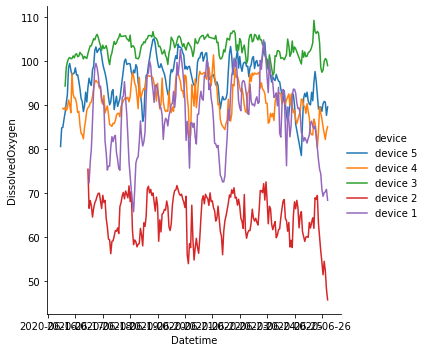

In [7]:
sns.relplot(x="Datetime", y="DissolvedOxygen", hue="device",  data=data_sorted, kind='line')

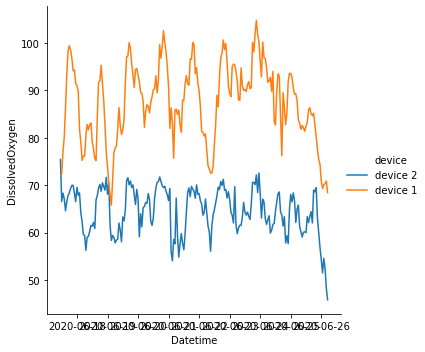

In [8]:
sns.relplot(x="Datetime", y="DissolvedOxygen", hue="device", kind="line", data=data_A)

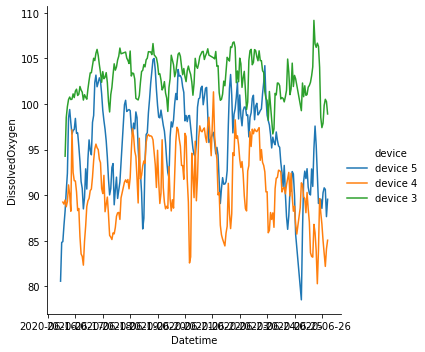

In [9]:
data_B = data_sorted[data_sorted["site"]=='site B']
sns.relplot(x="Datetime", y="DissolvedOxygen", hue="device", kind='line', data=data_B)

Ici nous remarquons beaucoup de volatilité avec une tendance qui semble journalière, mais qui reste difficile à juger au vu des séries.

Pour mieux visualiser, nous allons maintenant regarder les comportements moyens. Afin de visualiser au mieux les dépendances entre la variable d'intérêt "DissolvedOxygen" et les autres, nous prenons la moyenne des valeurs prises pour l'oxygène dissous pour une valeur prise d'une variable donnée. Par exemple dans le cas ci-dessous, nous prenons la moyenne de la variable 'DissolvedOxygen' pour une heure donnée et observons ainsi la courbe moyenne de 'DissolvedOxygen' selon l'heure.


In [10]:
mean_data_hour = data.groupby(['hour', 'device']).mean()
mean_data_water_temp = data.groupby(['WaterTemperature', 'device']).mean()
mean_data_weather_temp = data.groupby(['weather_temperature', 'device']).mean()
mean_data_wind = data.groupby(['windspeed', 'device']).mean()
mean_data_dew = data.groupby(['dewpoint', 'device']).mean()
mean_data_humidity = data.groupby(['humidity', 'device']).mean()
mean_data_wind_direction = data.groupby(['winddirection', 'device']).mean()
#print(mean_data_hour)

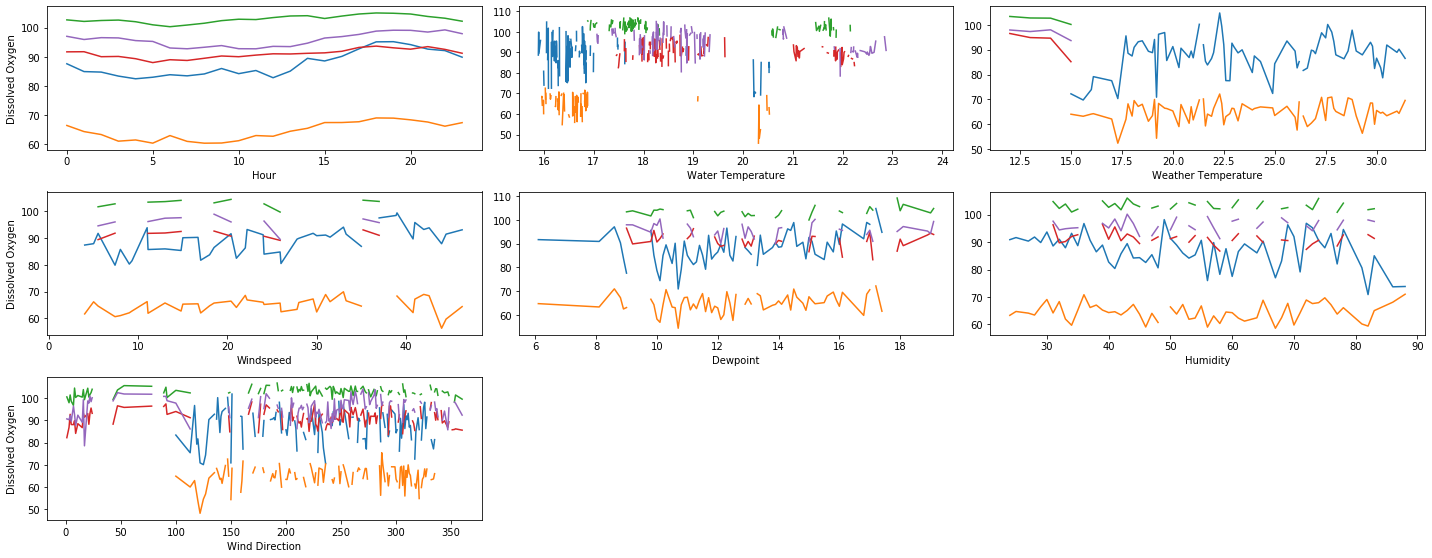

In [11]:
plt.subplots(figsize=(20,10))
plt.subplot(4, 3, 1)
plt.plot(mean_data_hour['DissolvedOxygen'].unstack()) 
plt.ylabel('Dissolved Oxygen')
plt.xlabel('Hour')
plt.subplot(4, 3, 2)
plt.plot(mean_data_water_temp['DissolvedOxygen'].unstack()) 
plt.xlabel('Water Temperature')
plt.subplot(4, 3, 3)
plt.plot(mean_data_weather_temp['DissolvedOxygen'].unstack()) 
plt.xlabel('Weather Temperature')
plt.subplot(4, 3, 4)
plt.plot(mean_data_wind['DissolvedOxygen'].unstack())
plt.xlabel('Windspeed')
plt.ylabel('Dissolved Oxygen')
plt.subplot(4, 3, 5)
plt.plot(mean_data_dew['DissolvedOxygen'].unstack())
plt.xlabel('Dewpoint')
plt.subplot(4, 3, 6)
plt.plot(mean_data_humidity['DissolvedOxygen'].unstack())
plt.xlabel('Humidity')
plt.subplot(4, 3, 7)
plt.plot(mean_data_wind_direction['DissolvedOxygen'].unstack())
plt.xlabel('Wind Direction')
plt.ylabel('Dissolved Oxygen')
plt.tight_layout()
plt.show()

Nous observons une certaine tendance journalière pour la variable 'DissolvedOxygen'. En effet, il semble que celle-ci soit plus élevée pendant la nuit indiquant sûrement une dépendance à la température ou à la luminosité. Cependant en regardant les autres graphiques, nous observons que ce soit pour la température 'weather' ou pour la température 'water' aucun pattern clair qui pourrait expliquer le point précédent. Cependant, ici, il faut faire attention à ces courbes moyennes. Comme nous pouvons le voir, elles sont discontinues à cause d'un manque d'observations pour certaines valeurs des variables et il est probable que pour une valeur donnée il n'y que très peu d'observations (l'aspect "courbe moyenne" peut donc être trompeur).

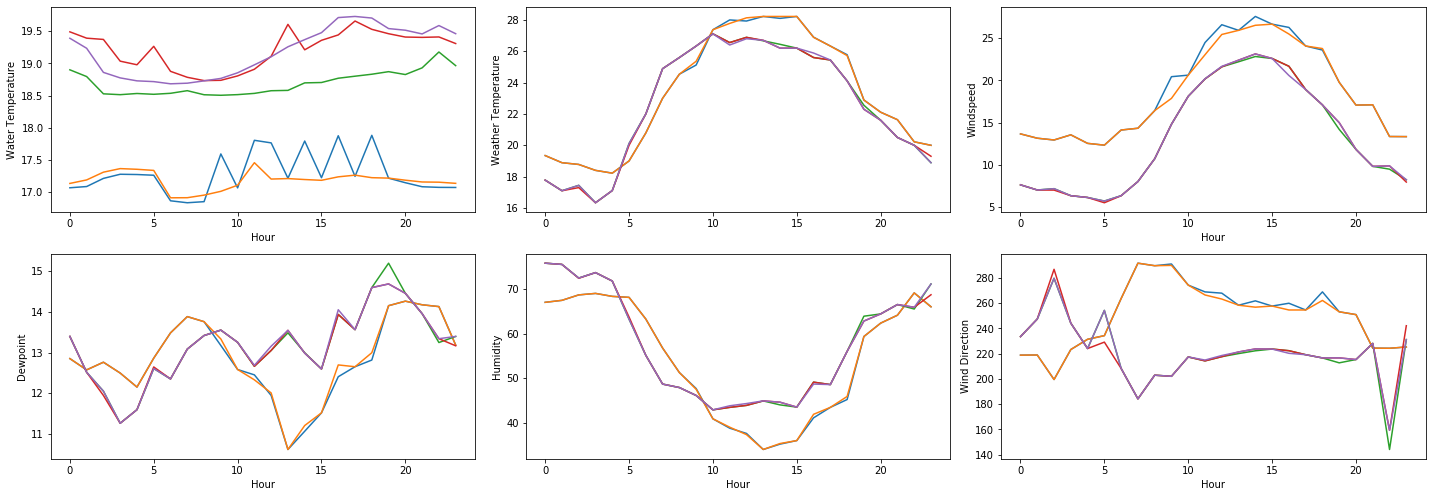

In [12]:
plt.subplots(figsize=(20,10))
plt.subplot(3, 3, 1)
plt.plot(mean_data_hour['WaterTemperature'].unstack()) 
plt.ylabel('Water Temperature')
plt.xlabel('Hour')
plt.subplot(3, 3, 2)
plt.plot(mean_data_hour['weather_temperature'].unstack()) 
plt.ylabel('Weather Temperature')
plt.subplot(3, 3, 3)
plt.plot(mean_data_hour['windspeed'].unstack()) 
plt.ylabel('Windspeed')
plt.xlabel('Hour')
plt.subplot(3, 3, 4)
plt.plot(mean_data_hour['dewpoint'].unstack())
plt.xlabel('Hour')
plt.ylabel('Dewpoint')
plt.subplot(3, 3, 5)
plt.plot(mean_data_hour['humidity'].unstack())
plt.xlabel('Hour')
plt.ylabel('Humidity')
plt.subplot(3, 3, 6)
plt.plot(mean_data_hour['winddirection'].unstack())
plt.ylabel('Wind Direction')
plt.xlabel('Hour')
plt.tight_layout()
plt.show()

## Modélisation

Pour la modélisation, nous utilisons les variables suivantes : 'WaterTemperature', 'device', 'site', 'weather_temperature', 'dewpoint', 'humidity', 'windspeed', 'winddirection', 'hour'. En plus de ceux-là, nous pouvons prendre en compte l'aspect temporel de notre variable d'intérêt. Pour cela, nous effectuons une analyse de la série et regardons les autocorrélations ainsi que les autocorrélations partielles pour chaque device. Lors de l'entraînement de nos algorithmes, l'échantillon sera découpé en deux parties, un training set composé de 70% des premières observations et le restant pour le test set. Afin de ne pas biaiser l'analyse des autocorrélations et comprendre les lags qui sont utiles à la prédiction nous faisons la même chose ici.

In [13]:
data_device_1 = data_sorted[data_sorted["device"]=='device 1']
data_device_2 = data_sorted[data_sorted["device"]=='device 2']
data_device_3 = data_sorted[data_sorted["device"]=='device 3']
data_device_4 = data_sorted[data_sorted["device"]=='device 4']
data_device_5 = data_sorted[data_sorted["device"]=='device 5']
data_device_1 = data_device_1[:int(data_device_1.shape[0]*0.7)]
data_device_2 = data_device_2[:int(data_device_2.shape[0]*0.7)]
data_device_3 = data_device_3[:int(data_device_3.shape[0]*0.7)]
data_device_4 = data_device_4[:int(data_device_4.shape[0]*0.7)]
data_device_5 = data_device_5[:int(data_device_5.shape[0]*0.7)]
#print(data_device_1['device'].unique())

### Analyse des autocorrélations de l'oxygène dissous pour chaque device

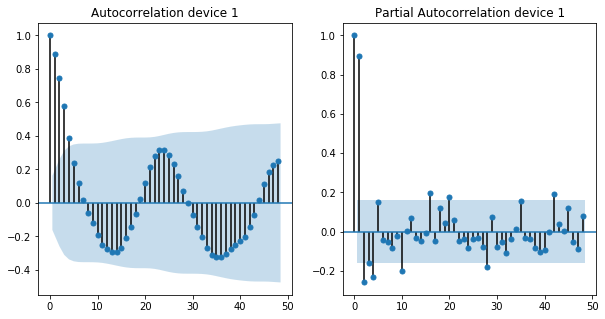

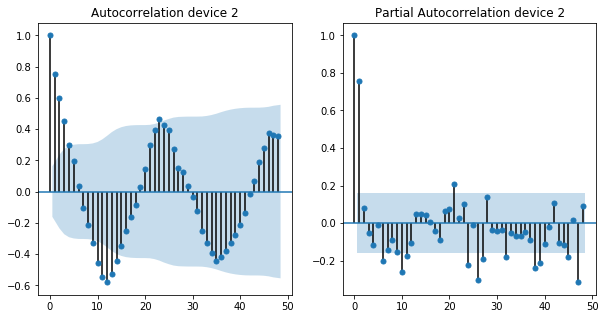

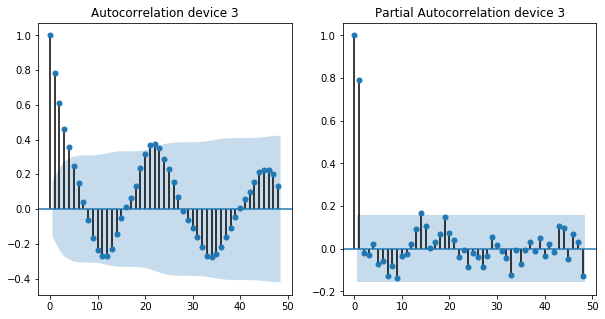

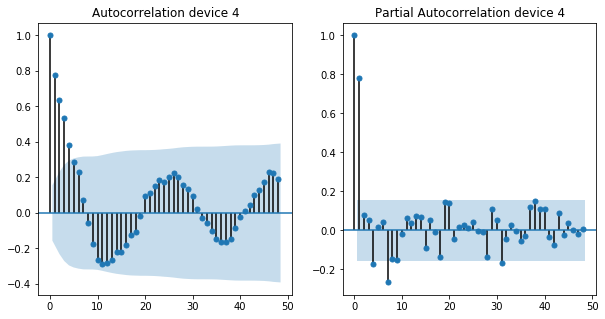

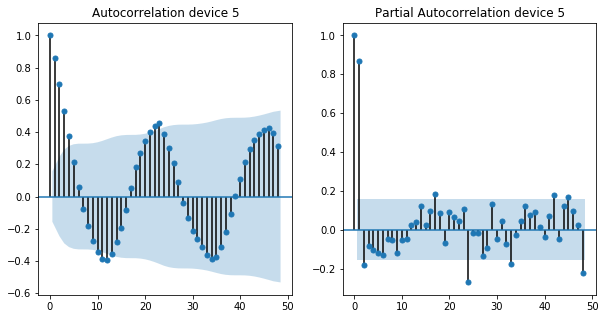

In [14]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(data_device_1["DissolvedOxygen"], lags=48, ax=ax[0], title='Autocorrelation device 1', fft=False);
plot_pacf(data_device_1["DissolvedOxygen"], lags=48, ax=ax[1], title='Partial Autocorrelation device 1');
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(data_device_2["DissolvedOxygen"], lags=48, ax=ax[0], title='Autocorrelation device 2', fft=False);
plot_pacf(data_device_2["DissolvedOxygen"], lags=48, ax=ax[1], title='Partial Autocorrelation device 2');
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(data_device_3["DissolvedOxygen"], lags=48, ax=ax[0], title='Autocorrelation device 3', fft=False);
plot_pacf(data_device_3["DissolvedOxygen"], lags=48, ax=ax[1], title='Partial Autocorrelation device 3');
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(data_device_4["DissolvedOxygen"], lags=48, ax=ax[0], title='Autocorrelation device 4', fft=False);
plot_pacf(data_device_4["DissolvedOxygen"], lags=48, ax=ax[1], title='Partial Autocorrelation device 4');
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(data_device_5["DissolvedOxygen"], lags=48, ax=ax[0], title='Autocorrelation device 5', fft=False);
plot_pacf(data_device_5["DissolvedOxygen"], lags=48, ax=ax[1], title='Partial Autocorrelation device 5');

Ces graphiques d'autocorrélation  montre une très nette présence d'autocorrélation. Nous conservons les lags dont les valeurs dépassent les intervalles de confiance. Ici, il faut faire attention au "décalage" des lags. Notre but n'est pas de prévoir l'oxygène dissous à l'instant t (comme représenté par les graphiques) mais les instants t+1, .. t+6. La prochaine étape est d'ajouter les lags obtenus par les graphiques précédents, ainsi que les horizons qu'on souhaite prévoir à notre jeu de données.

In [15]:
#lags obtenues par les plot acf/pacf
lags_acf = [1,2,3,4,9,10,11,12,13,14,21,22,23]
lags_pacf = [1,2,4,6,7,9,10,11,12,14,16,17,20,21,24,26,27,31,32,33,38,39,42,45,46,48]
lags_considered = np.unique(sorted(lags_acf + lags_pacf))-1
lags_considered = lags_considered[1:]
#print(len(lags_considered))

In [16]:
#Augmentation des données par les lags 
#Pour construire les lags de l'oxygène dissous, il faut d'abord créer les lags pour chacun des devices et ensuiter les recombiner avec la matrice initiale
data_device_1 = data_sorted[data_sorted["device"]=='device 1']
data_device_2 = data_sorted[data_sorted["device"]=='device 2']
data_device_3 = data_sorted[data_sorted["device"]=='device 3']
data_device_4 = data_sorted[data_sorted["device"]=='device 4']
data_device_5 = data_sorted[data_sorted["device"]=='device 5']

dissolved_ox_1 = data_device_1["DissolvedOxygen"]
dissolved_ox_2 = data_device_2["DissolvedOxygen"]
dissolved_ox_3 = data_device_3["DissolvedOxygen"]
dissolved_ox_4 = data_device_4["DissolvedOxygen"]
dissolved_ox_5 = data_device_5["DissolvedOxygen"]
Data_DO_Lag_1 = pd.DataFrame(dissolved_ox_1)
Data_DO_Lag_2 = pd.DataFrame(dissolved_ox_2)
Data_DO_Lag_3 = pd.DataFrame(dissolved_ox_3)
Data_DO_Lag_4 = pd.DataFrame(dissolved_ox_4)
Data_DO_Lag_5 = pd.DataFrame(dissolved_ox_5)
lags_name = ['DO_t']

#construction des lags issus de l'acf/pacf
for lag in lags_considered :
    Data_DO_Lag_1 = pd.concat([Data_DO_Lag_1, dissolved_ox_1.shift(lag) ], axis=1)
    Data_DO_Lag_2 = pd.concat([Data_DO_Lag_2, dissolved_ox_2.shift(lag) ], axis=1)
    Data_DO_Lag_3 = pd.concat([Data_DO_Lag_3, dissolved_ox_3.shift(lag) ], axis=1)
    Data_DO_Lag_4 = pd.concat([Data_DO_Lag_4, dissolved_ox_4.shift(lag) ], axis=1)
    Data_DO_Lag_5 = pd.concat([Data_DO_Lag_5, dissolved_ox_5.shift(lag) ], axis=1)
    name_temp_lag = 'DO_t_'+str(lag)
    lags_name.append(name_temp_lag)
   
#Data_DO_Lag.columns = lags_name
#print(Data_DO_Lag)
#Ici nous ajoutons les lags que nous voulons prévoir
lags_forecast = [-1,-2,-3,-4,-5,-6]
for lag in lags_forecast:
    Data_DO_Lag_1 = pd.concat([ dissolved_ox_1.shift(lag), Data_DO_Lag_1 ], axis=1)
    Data_DO_Lag_2 = pd.concat([ dissolved_ox_2.shift(lag), Data_DO_Lag_2 ], axis=1)
    Data_DO_Lag_3 = pd.concat([ dissolved_ox_3.shift(lag), Data_DO_Lag_3 ], axis=1)
    Data_DO_Lag_4 = pd.concat([ dissolved_ox_4.shift(lag), Data_DO_Lag_4 ], axis=1)
    Data_DO_Lag_5 = pd.concat([ dissolved_ox_5.shift(lag), Data_DO_Lag_5 ], axis=1)
    name_temp_lag = 'DO_t+' + str(lag)[1:]
    lags_name.insert(0,name_temp_lag)
    
Data_DO_Lag_1.columns = lags_name
Data_DO_Lag_2.columns = lags_name
Data_DO_Lag_3.columns = lags_name
Data_DO_Lag_4.columns = lags_name
Data_DO_Lag_5.columns = lags_name

#on concatène chaque device avec sa matrice de départ
Data_DO_Lag_1 = pd.concat([Data_DO_Lag_1, data_device_1], axis=1)
Data_DO_Lag_2 = pd.concat([Data_DO_Lag_2, data_device_2 ], axis=1)
Data_DO_Lag_3 = pd.concat([Data_DO_Lag_3, data_device_3 ], axis=1)
Data_DO_Lag_4 = pd.concat([Data_DO_Lag_4, data_device_4 ], axis=1)
Data_DO_Lag_5 = pd.concat([Data_DO_Lag_5, data_device_5 ], axis=1)

#On enlève les observations où on ne peut pas avoir de lags
Data_DO_Lag_1 = Data_DO_Lag_1.drop(Data_DO_Lag_1.index[0:47])
Data_DO_Lag_1 = Data_DO_Lag_1.drop(Data_DO_Lag_1.index[-6:])
Data_DO_Lag_2 = Data_DO_Lag_2.drop(Data_DO_Lag_2.index[0:47])
Data_DO_Lag_2 = Data_DO_Lag_2.drop(Data_DO_Lag_2.index[-6:])
Data_DO_Lag_3 = Data_DO_Lag_3.drop(Data_DO_Lag_3.index[0:47])
Data_DO_Lag_3 = Data_DO_Lag_3.drop(Data_DO_Lag_3.index[-6:])
Data_DO_Lag_4 = Data_DO_Lag_4.drop(Data_DO_Lag_4.index[0:47])
Data_DO_Lag_4 = Data_DO_Lag_4.drop(Data_DO_Lag_4.index[-6:])
Data_DO_Lag_5 = Data_DO_Lag_5.drop(Data_DO_Lag_5.index[0:47])
Data_DO_Lag_5 = Data_DO_Lag_5.drop(Data_DO_Lag_5.index[-6:])

#On concatène les cinq device
Data_DO_big = pd.concat([Data_DO_Lag_1, Data_DO_Lag_2, Data_DO_Lag_3, Data_DO_Lag_4, Data_DO_Lag_5], axis=0).sort_values(['Datetime', 'device'])
#print(data_sorted['DissolvedOxygen'][0:20])
#print(Data_DO_big)
#print(lags_name)

In [17]:
#ici on transforme device et site en variables catégorielles
Data_DO_big= Data_DO_big.replace(to_replace=['device 1', 'device 2', 'device 3', 'device 4', 'device 5'], value=[1, 2,3,4,5])
Data_DO_big = Data_DO_big.replace(to_replace=['site A', 'site B'], value=[1, 2])
Data_DO_big["device"] = Data_DO_big["device"].astype('category')
Data_DO_big["site"] = Data_DO_big["site"].astype('category')
#On retire les variables qui ne seront plus utiles pour la suite
Data_DO_big = Data_DO_big.drop(columns = ['Unnamed: 0','Datetime'])
#print(Data_DO_big)

Ici, nous allons opter pour l'utilisation des forêts aléatoires comme premier algorithme de prévision, en prenant les variables mentionnées précédemment. Les forêts aléatoires sont connues pour donner une bonne performance tout en étant rapide à calculer, à tuner, ce quel que soit le type de donnée à l'entrée. C'est pour cela que cette méthode est bonne pour donner un bon premier benchmark à un jeu de données. De plus, les données n'ont pas besoin d'être transformées contrairement à d'autres techniques plus traditionnelles. Au vu du nombre d'observations et de variables dans le jeu de données, il ne sera pas judicieux d'utiliser des réseaux de neurones et ce type de méthodes ne sera donc pas considéré par la suite. Avant de lancer l'algorithme, nous séparons le jeu de données en deux parties, un training set composé de 70% des données et un test set avec le reste des observations. Cette séparation training/test set ne peut pas être fait de manière standard, car nous avons à faire à des séries temporelles ici. Le training set correspond temporellement aux 70% premières observations et la fin pour le test set.

L'évaluation la plus classique dans ce cadre est le mean squared error (qui est généralement le critère minimisé en régression). Celui-ci mesure l'écart moyen quadratique des prédictions par rapport aux observations. Un critère parfois plus simple à interpréter est l'erreur moyenne absolue qui mesure l'erreur de manière plus direct.

In [18]:
X = Data_DO_big[['WaterTemperature', 'device', 'site','weather_temperature', 'dewpoint', 'humidity', 
                    'windspeed', 'winddirection', 'hour', 'DO_t', 'DO_t_1', 'DO_t_2', 'DO_t_3', 
                    'DO_t_5',  'DO_t_6', 'DO_t_8', 'DO_t_9', 'DO_t_10', 'DO_t_11', 'DO_t_12', 'DO_t_13', 
                    'DO_t_15', 'DO_t_16', 'DO_t_19', 'DO_t_20', 'DO_t_21', 'DO_t_22', 'DO_t_23', 'DO_t_25', 
                    'DO_t_26', 'DO_t_30', 'DO_t_31', 'DO_t_32', 'DO_t_37', 'DO_t_38', 'DO_t_41', 'DO_t_44', 
                    'DO_t_45', 'DO_t_47']]

y = Data_DO_big[['DO_t+1', 'DO_t+2', 'DO_t+3', 'DO_t+4', 'DO_t+5', 'DO_t+6']]
#séparation train/test set
X_train = X[:int(X.shape[0]*0.7)]
X_test = X[int(X.shape[0]*0.7):]
y_train = y[:int(X.shape[0]*0.7)]
y_test = y[int(X.shape[0]*0.7):]
#print(X_train)
#print(y_train)
#print(X.dtypes)
#print(X)

### Premier modèle

Comme mentionné, précédemment, notre premier modèle sera basé sur les forêts aléatoires. Cependant, ici, nous nous intéressons à une sortie multidimensionnelle. La forêt aléatoire est conçue pour une sortie d'une dimension normalement. Ici, nous utilisons donc MultiOutputRegressor qui permet de construire une sortie multiple en construisant un estimateur pour chaque sortie indépendamment des autres. Par la suite, nous utiliserons aussi RegressorChain permettant d'utiliser les sorties des autres estimateurs dans un ordre donné (typiquement utilisé la prévision de t+1 et t+2 pour la prévision de t+3).

In [19]:
# create regressor object 
regressor_rf = MultiOutputRegressor(RandomForestRegressor(n_estimators = 200, max_features = 39, random_state = 0)); 
# fit the regressor with x and y data 
regressor_rf.fit(X_train, y_train);

In [20]:
predict_rf = regressor_rf.predict(X_test)
#residus_rf = (y_test - predict_rf).tolist()
print("Erreur mse sur le test set : ", mean_squared_error(y_test, predict_rf,  multioutput='raw_values'))
print("Erreur mae sur le test set : ", mean_absolute_error(y_test, predict_rf,  multioutput='raw_values'))
print("Ecart type de 'count' sur le test set : ", np.std(y_test))

Erreur mse sur le test set :  [11.9585461  28.00202544 40.0329441  50.17242212 55.21789403 59.66358331]
Erreur mae sur le test set :  [2.66832309 4.057449   4.92864254 5.52023571 5.68923427 5.7926509 ]
Ecart type de 'count' sur le test set :  DO_t+1    13.512483
DO_t+2    13.606137
DO_t+3    13.659050
DO_t+4    13.787238
DO_t+5    13.943067
DO_t+6    14.087542
dtype: float64


Nous prenons ces résultats comme benchmark d'une part, mais également pour le choix des variables. En effet, nous avons beaucoup de variables explicatives et il serait intéressant de prendre uniquement en compte les variables qui aident au problème de prédiction. Cela permettra d'adapter les méthodes et d'avoir de meilleures prévisions.

Les forêts aléatoires ont l'avantage de calculer l'importance des variables directement sur l'échantillon d'entraînement. L'importance des variables n'est donc pas biaisée par le test set et peut être utilisée pour d'autres analyses sans biaiser les résultats. L'importance des variables est obtenue en permutant aléatoirement les variables une à une et voir l'impact sur la prévision. Par exemple, si la variable "hour" a beaucoup d'importance dans le modèle, alors permuter aléatoirement par une autre valeur de cette variable aura un impact significatif sur la prévision et entraîne une augmentation de l'erreur. Inversement, si la variable n'est pas considérée utile, alors le fait de permuter au hasard n'aura pas d'impact sur la prévision et l'erreur ne bougera pas. 

Concernant les performances, la seule autre comparaison que l'on a pour le moment est l'écart-type de l'oxygène dissous. On peut voir cette dernière comme la racine de l'erreur quadratique lorsque l'estimateur considéré est la moyenne empirique. Afin de comparer des choses équivalentes, il faut prendre la racine du mse. Cela nous donne un rmse (root mean squared error) entre 3.48 (pour t+1) à 7.72 (pour t+6). Que ce soit pour le rmse ou pour la mae, nous obtenons des estimateurs bien meilleurs (L'erreur est divisée respectivement par 3.9 (rmse), 5 (mae) pour la prévision en t+1 et par 1.8 (rmse), 2.3 (mae) pour la prévision en t+6). Ici, il est évidemment attendu que la prévision à t+6 est moins bonne étant donnée qu'elle devrait très probablement dépendre des valeurs t+4, t+5 qui ne sont pas inclus ici.

[1.402513074267528e-05, 0.00039346336517550576, 0.0007648921163652166, 0.0007998144245196259, 0.0009034285931823581, 0.0009406724158922413, 0.0009761446110965827, 0.0010189278829889187, 0.0010243517798393315, 0.001044337513101506, 0.001214930194051499, 0.0012369282315330557, 0.0012380085818640724, 0.0013098979453301555, 0.0013212339753744307, 0.001397546003104665, 0.00144887476374798, 0.0014528611839245908, 0.0015002605155237775, 0.0015999324225201722, 0.0018750381416233535, 0.00208009223979924, 0.0022861717279720026, 0.002548426503341108, 0.002609143862350381, 0.0026198581093593173, 0.0028606563344976336, 0.002992209145737844, 0.003113481969245959, 0.004935259199723779, 0.0053556810221203, 0.006064798551657251, 0.009262223596597636, 0.00937442329214369, 0.01295597103825958, 0.015603095970680485, 0.015665618996279287, 0.08542625585519435, 0.7907710627935384]


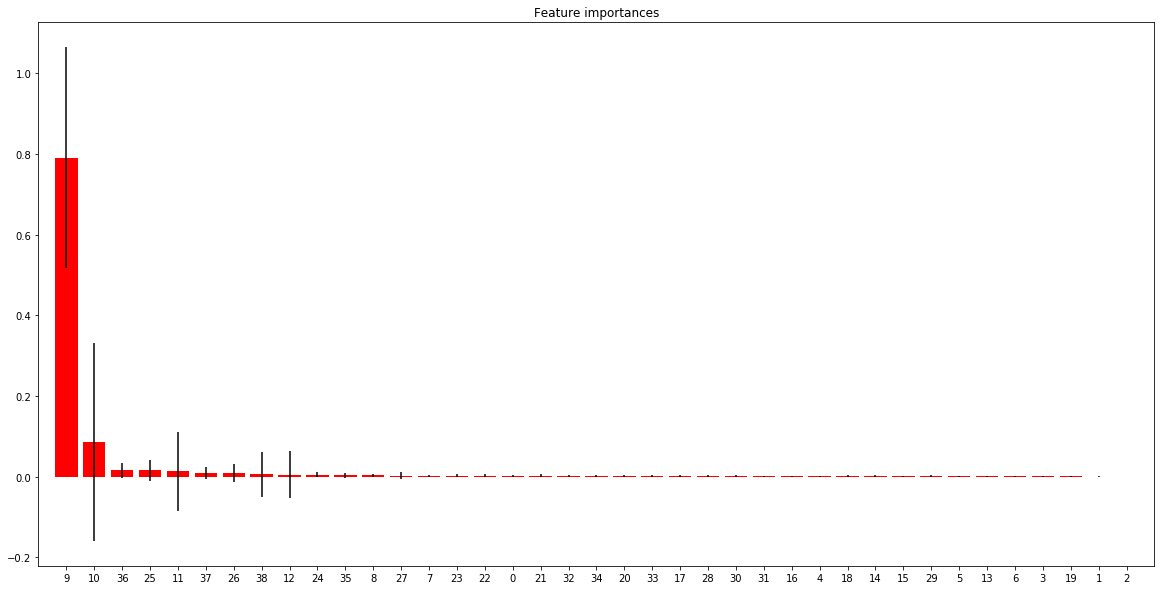

In [21]:
estim_ = 1
print(sorted(regressor_rf.estimators_[estim_].feature_importances_))

#on garde les features > 1%
importances = regressor_rf.estimators_[estim_].feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor_rf.estimators_[estim_]],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [22]:
print("Variables importantes pour la prévision à t+1 :", X.columns[[9,10,11]].tolist()) #pour t+1
print("Variables importantes pour la prévision à t+2 :",X.columns[[9,10,36,25,11]].tolist()) #pour t+2
print("Variables importantes pour la prévision à t+3 :",X.columns[[9,10,25,37,24,36,11]].tolist()) #pour t+3
print("Variables importantes pour la prévision à t+4 :",X.columns[[9,36,10,24,37,23,11,13,25,38]].tolist()) #pour t+4
print("Variables importantes pour la prévision à t+5 :",X.columns[[9,37,23,36,12,13,10,11,14,35,24,7]].tolist()) #pour t+5
print("Variables importantes pour la prévision à t+6 :",X.columns[[9,36,37,13,10,12,11,14,23,35,22,7,0]].tolist()) #pour t+6

Variables importantes pour la prévision à t+1 : ['DO_t', 'DO_t_1', 'DO_t_2']
Variables importantes pour la prévision à t+2 : ['DO_t', 'DO_t_1', 'DO_t_44', 'DO_t_21', 'DO_t_2']
Variables importantes pour la prévision à t+3 : ['DO_t', 'DO_t_1', 'DO_t_21', 'DO_t_45', 'DO_t_20', 'DO_t_44', 'DO_t_2']
Variables importantes pour la prévision à t+4 : ['DO_t', 'DO_t_44', 'DO_t_1', 'DO_t_20', 'DO_t_45', 'DO_t_19', 'DO_t_2', 'DO_t_5', 'DO_t_21', 'DO_t_47']
Variables importantes pour la prévision à t+5 : ['DO_t', 'DO_t_45', 'DO_t_19', 'DO_t_44', 'DO_t_3', 'DO_t_5', 'DO_t_1', 'DO_t_2', 'DO_t_6', 'DO_t_41', 'DO_t_20', 'winddirection']
Variables importantes pour la prévision à t+6 : ['DO_t', 'DO_t_44', 'DO_t_45', 'DO_t_5', 'DO_t_1', 'DO_t_3', 'DO_t_2', 'DO_t_6', 'DO_t_19', 'DO_t_41', 'DO_t_16', 'winddirection', 'WaterTemperature']


En gardant uniquement les variables qui ont une importance plus grande que 1%, nous obtenons les variables listées ci-dessus. Maintenant que nous connaissons les variables "importantes" d'après la méthode précédente, une première idée serait d'uniquement prendre ces variables en considération pour une nouvelle analyse. Sur le training set, nous allons également faire une validation croisée pour choisir les paramètres des forêts aléatoires plus finement et permettre d'avoir de meilleures performances. Comme pour la séparation training/test set, la validation croisée ne peut pas se faire de manière standard sur des données temporelles. Ici, nous allons utiliser la version série temporelle de la validation croisée avec le nombre de splits égale à 5.

### Deuxième modèle : RF après réduction de dimension

In [23]:
#création du dataset réduit
X_reduced = Data_DO_big[['WaterTemperature', 'winddirection', 'DO_t', 'DO_t_1', 'DO_t_2', 'DO_t_3', 
                        'DO_t_5', 'DO_t_6', 'DO_t_16', 'DO_t_19', 'DO_t_20', 'DO_t_21',  
                        'DO_t_41', 'DO_t_44', 'DO_t_45', 'DO_t_47']]
#y = data_augmented['DO_t+1']
#séparation train/test set
X_reduced_train = X_reduced[:int(X_reduced.shape[0]*0.7)]
X_reduced_test = X_reduced[int(X_reduced.shape[0]*0.7):]
#print(np.shape(X_reduced_train))
#print(y_train.columns)

In [24]:
param_grid = {
                 'n_estimators': [200,300,400],
                 'max_features': [i for i in range(1,17)]
             }


#print(param_grid)
# 5-Fold Cross validation Time series version
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_reduced_train):
    #print(tr_index, val_index)
    X_tr, X_val = X_reduced_train.iloc[tr_index], X_reduced_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[tr_index], y_train.iloc[val_index]
    #y_tr, y_val = y_train[tr_index], y_train[val_index]
    for mf in param_grid['max_features']:
        for ne in param_grid['n_estimators']:
            #Construit un estimateur pour chaque sortie comme si tout était indépendant
            rfr = MultiOutputRegressor(RandomForestRegressor(max_features=int(mf),n_estimators=int(ne)))
            rfr.fit(X_tr, y_tr)
            predict_rfr = rfr.predict(X_val)
            #print(predict_rfr)
            score.append([i,
                          mf, 
                          ne, 
                          mean_squared_error(y_val, predict_rfr,  multioutput='raw_values'),
                          mean_absolute_error(y_val, predict_rfr,  multioutput='raw_values')])
    i += 1

In [25]:
#print(score)
score_average_mse = list()
score_average_mae = list()
for mf in param_grid['max_features']:
        for ne in param_grid['n_estimators']:
            get_score_mse = []
            get_score_mae = []
            for i in range(len(score)):
                temp_score = score[i]
                if temp_score[1]==mf and temp_score[2]==ne:
                    score_mean_mse = mean(temp_score[3])
                    score_mean_mae = mean(temp_score[4])
                    get_score_mse.append(score_mean_mse)
                    get_score_mae.append(score_mean_mae)
            score_average_mse.append([mf, ne, mean(get_score_mse)])
            score_average_mae.append([mf, ne, mean(get_score_mae)])
            #print(score[0][3])

In [26]:
min_param_mse_index = 0
current_best_mse = score_average_mse[0][2]
min_param_mae_index = 0
current_best_mae = score_average_mae[0][2]
for u in score_average_mse:
    if u[2] < current_best_mse:
        min_param_mse_index = score_average_mse.index(u)
        current_best_mse = u[2]
for u in score_average_mae:        
    if u[2] < current_best_mae:
        min_param_mae_index = score_average_mae.index(u)
        current_best_mae = u[2]

In [27]:
print("Meilleur paramètre pour le critère mse. Nombre de features max :", score_average_mse[min_param_mse_index][0], "Nombre d'arbres : ", score_average_mse[min_param_mse_index][1])
print("Meilleur paramètre pour le critère mae. Nombre de features max :", score_average_mae[min_param_mae_index][0], "Nombre d'arbres : ", score_average_mae[min_param_mae_index][1])

Meilleur paramètre pour le critère mse. Nombre de features max : 3 Nombre d'arbres :  200
Meilleur paramètre pour le critère mae. Nombre de features max : 7 Nombre d'arbres :  400


In [28]:
# create regressor object 
rfr_mse = MultiOutputRegressor(RandomForestRegressor(max_features=3,n_estimators=200, random_state = 0))
# fit the regressor with x and y data 
rfr_mse.fit(X_reduced_train, y_train) 

predict_rf = rfr_mse.predict(X_reduced_test)
print("Erreur mse sur le test set : ", mean_squared_error(y_test, predict_rf,  multioutput='raw_values'))
print("Erreur mae sur le test set : ", mean_absolute_error(y_test, predict_rf,  multioutput='raw_values'))

Erreur mse sur le test set :  [20.58723823 33.6402247  44.37786621 53.54193822 60.03688723 62.62005451]
Erreur mae sur le test set :  [3.4028429  4.37470231 5.08298082 5.53025348 5.85725512 5.90568872]


Ici, nous observons que les erreurs ont clairement augmenté par rapport à précédemment. Notre sélection de variables précédente était sûrement trop "brutale" et a entrainé une perte d'information pour la prévision. Observons les résidus sur le training set.

In [29]:
predict_train_rf = rfr_mse.predict(X_reduced_train)
residus_rf = (y_train - predict_train_rf)

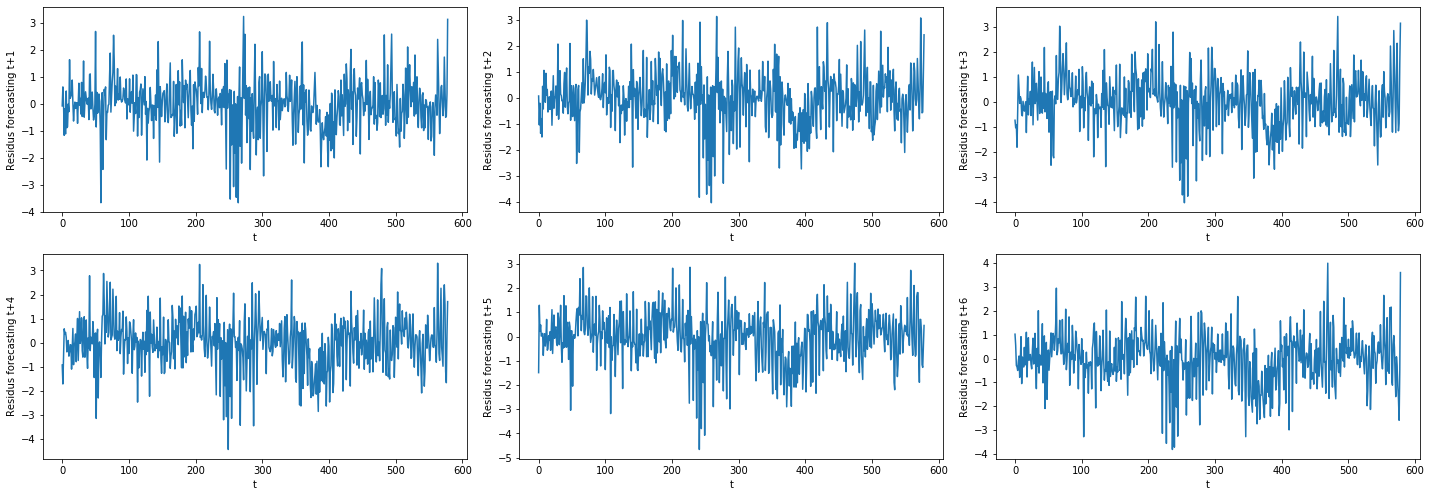

In [30]:
t = [i for i in range(0,len(residus_rf['DO_t+1']))]
#print(t)
plt.subplots(figsize=(20,10))
plt.subplot(3, 3, 1)
plt.plot(t, residus_rf['DO_t+1']) 
plt.ylabel('Residus forecasting t+1')
plt.xlabel('t')
plt.subplot(3, 3, 2)
plt.plot(t, residus_rf['DO_t+2']) 
plt.ylabel('Residus forecasting t+2')
plt.xlabel('t')
plt.subplot(3, 3, 3)
plt.plot(t, residus_rf['DO_t+3']) 
plt.ylabel('Residus forecasting t+3')
plt.xlabel('t')
plt.subplot(3, 3, 4)
plt.plot(t, residus_rf['DO_t+4']) 
plt.ylabel('Residus forecasting t+4')
plt.xlabel('t')
plt.subplot(3, 3, 5)
plt.plot(t, residus_rf['DO_t+5']) 
plt.ylabel('Residus forecasting t+5')
plt.xlabel('t')
plt.subplot(3, 3, 6)
plt.plot(t, residus_rf['DO_t+6']) 
plt.ylabel('Residus forecasting t+6')
plt.xlabel('t')
plt.tight_layout()
plt.show()


Au vu des plots ci-dessus, nous observons qu'il reste un certain pattern très net dans les résidus, signifiant que certains lags n'ont pas été capturés par la forêt et se retrouvent ainsi dans les résidus. Ceci est confirmé par les graphiques d'autocorrélation qui suivent.

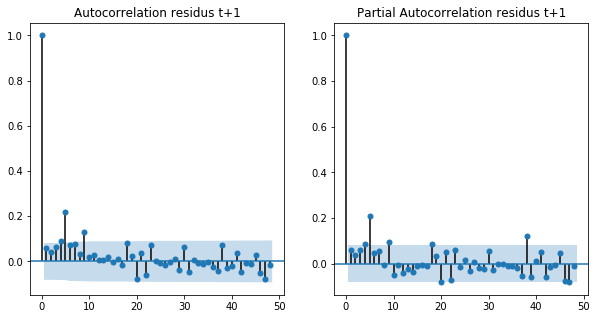

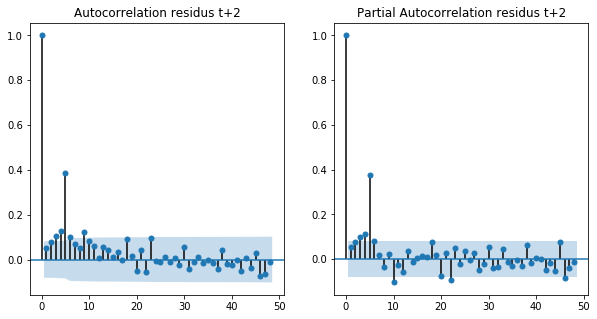

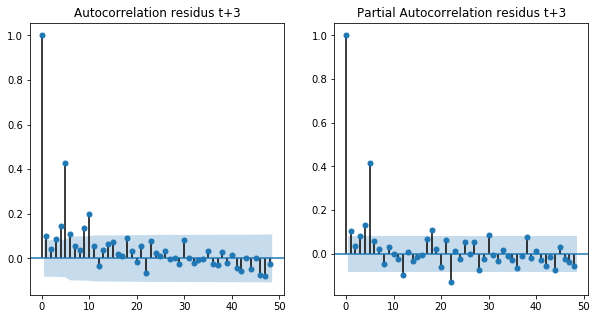

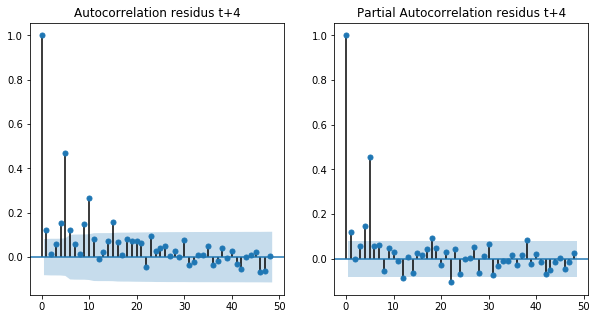

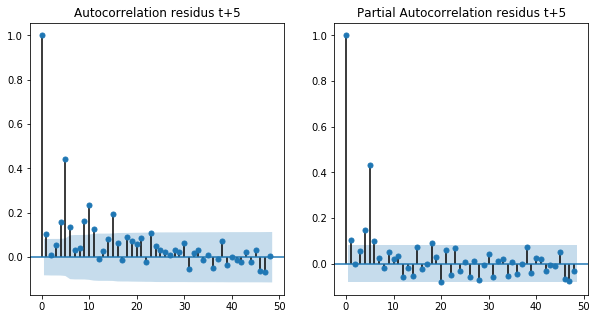

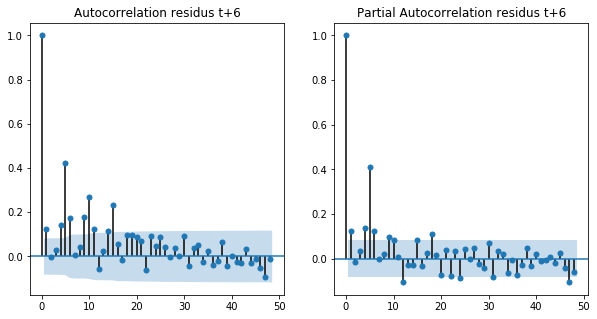

In [31]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(residus_rf['DO_t+1'], lags=48, ax=ax[0], title='Autocorrelation residus t+1');
plot_pacf(residus_rf['DO_t+1'], lags=48, ax=ax[1], title='Partial Autocorrelation residus t+1');
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(residus_rf['DO_t+2'], lags=48, ax=ax[0], title='Autocorrelation residus t+2');
plot_pacf(residus_rf['DO_t+2'], lags=48, ax=ax[1], title='Partial Autocorrelation residus t+2');
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(residus_rf['DO_t+3'], lags=48, ax=ax[0], title='Autocorrelation residus t+3');
plot_pacf(residus_rf['DO_t+3'], lags=48, ax=ax[1], title='Partial Autocorrelation residus t+3');
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(residus_rf['DO_t+4'], lags=48, ax=ax[0], title='Autocorrelation residus t+4');
plot_pacf(residus_rf['DO_t+4'], lags=48, ax=ax[1], title='Partial Autocorrelation residus t+4');
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(residus_rf['DO_t+5'], lags=48, ax=ax[0], title='Autocorrelation residus t+5');
plot_pacf(residus_rf['DO_t+5'], lags=48, ax=ax[1], title='Partial Autocorrelation residus t+5');
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(residus_rf['DO_t+6'], lags=48, ax=ax[0], title='Autocorrelation residus t+6');
plot_pacf(residus_rf['DO_t+6'], lags=48, ax=ax[1], title='Partial Autocorrelation residus t+6');

Nous observons dans les graphiques d'auto-corrélation des résidus une forte présence de certains lags signifiant que la méthode n'a pas su les capturer et qu'il reste à repérer du signal. 

### Troisième modèle : RF Prévisions injectées

Nous allons revenir à notre première méthode avant le choix de certaines variables par l'importance. Cette fois au lieu de prendre la méthode MultiOutputRegressor nous utilisons RegressorChain qui permet d'injecter pour la prévision à t+k les prévisions t+k-1, ... t+1.

In [32]:
# create regressor object 
regressor_rf_chain = RegressorChain(RandomForestRegressor(n_estimators = 200, max_features = 39, random_state = 0))
# fit the regressor with x and y data 
regressor_rf_chain.fit(X_train, y_train) 

RegressorChain(base_estimator=RandomForestRegressor(max_features=39,
                                                    n_estimators=200,
                                                    random_state=0))

In [33]:
predict_rf_chain = regressor_rf_chain.predict(X_test)
print("Erreur mse sur le test set : ", mean_squared_error(y_test, predict_rf_chain,  multioutput='raw_values'))
print("Erreur mae sur le test set : ", mean_absolute_error(y_test, predict_rf_chain,  multioutput='raw_values'))

Erreur mse sur le test set :  [11.9585461  24.86203598 35.22331511 43.40612919 50.41625924 55.72370551]
Erreur mae sur le test set :  [2.66832309 3.83112329 4.55408404 4.98451245 5.33034699 5.57093266]


Les valeurs que nous avions pour la première méthode sont respectivement [11.97, 28.00, 40.03, 50.17, 55.22, 59.66] pour le mse et [2.67, 4.06, 4.93, 5.52, 5.69, 5.79] pour la mae. Il n'est pas étonnant que l'erreur ne change pas pour la prévision pour t+1 (il n'y a pas de prévision à injecter). Cependant, nous observons une nette amélioration pour les prévisions de t+2 (11% d'amélioration relative en mse, 6% en mae) à t+6 (7% en mse, 4% en mae).

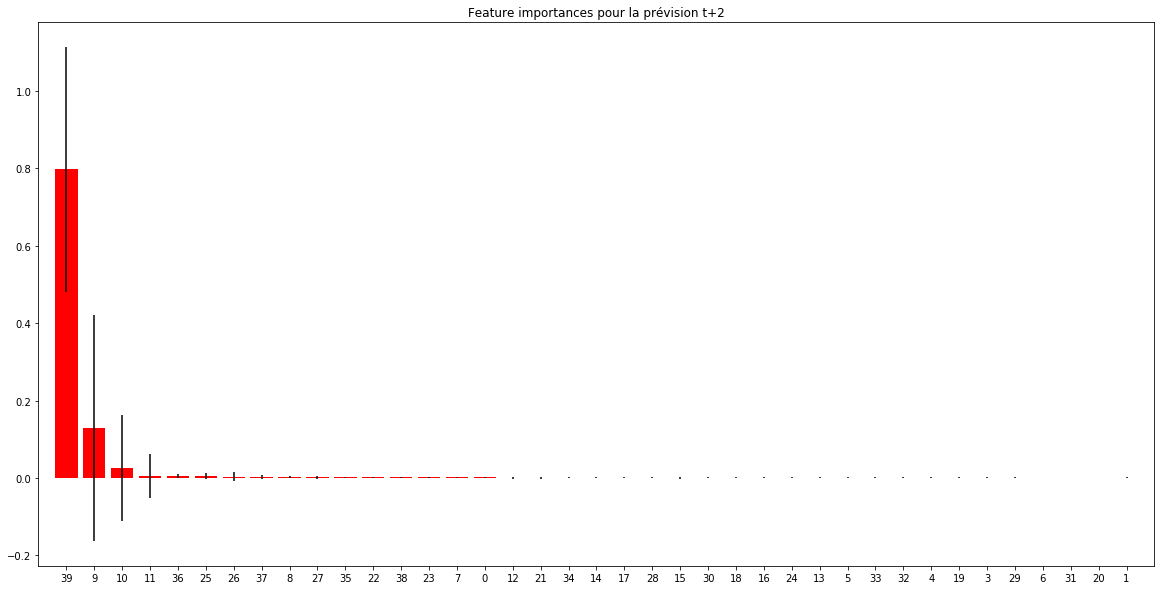

In [34]:
estim_ = 1
#print(sorted(regressor_rf_chain.estimators_[estim_].feature_importances_))
#on garde les features > 1%
importances = regressor_rf_chain.estimators_[estim_].feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor_rf_chain.estimators_[estim_]],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")

#for f in range(X.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances pour la prévision t+2")
plt.bar(range(len(regressor_rf_chain.estimators_[estim_].feature_importances_)), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [35]:
print("Variables importantes pour la prévision à t+1 :", X.columns[[9,10,11]]) #pour t+1
print("Variables importantes pour la prévision à t+2 :",X.columns[[9,10]], "+ la prévision t+1.") #pour t+2
print("Variables importantes pour la prévision à t+3 :",X.columns[[9]], "+ les prévisions t+1 et t+2.") #pour t+3
print("Variables importantes pour la prévision à t+4 : les prévisions t+1, t+2, t+3.") #pour t+4
print("Variables importantes pour la prévision à t+5 : les prévisions t+2, t+3, t+4.") #pour t+5
print("Variables importantes pour la prévision à t+6 : les prévisions t+3, t+4, t+5.") #pour t+6

Variables importantes pour la prévision à t+1 : Index(['DO_t', 'DO_t_1', 'DO_t_2'], dtype='object')
Variables importantes pour la prévision à t+2 : Index(['DO_t', 'DO_t_1'], dtype='object') + la prévision t+1.
Variables importantes pour la prévision à t+3 : Index(['DO_t'], dtype='object') + les prévisions t+1 et t+2.
Variables importantes pour la prévision à t+4 : les prévisions t+1, t+2, t+3.
Variables importantes pour la prévision à t+5 : les prévisions t+2, t+3, t+4.
Variables importantes pour la prévision à t+6 : les prévisions t+3, t+4, t+5.


L'utilisation du dernier algorithme permet d'injecter directement la valeur prévue pour l'instant d'avant : une forêt est calculée pour prévoir t+1, cette prévision est ensuite utilisée pour prédire t+2 et ainsi de suite. Lorsqu'on observe l'importance des variables pour ce cas-là, nous remarquons qu'en fait les plus importantes sont les trois valeurs précédentes de l'oxygène dissous (même si celles-ci sont des prévisions). Cette méthode améliore nettement les performances par rapport à la méthode précédente, mais ne considère jamais les autres variables. Cependant, en observant les résidus (graphiques ci-dessous) nous observons toujours une dépendance dans ceux-ci et donc effectivement, au moins des lags qui n'ont pas été capturés correctement. 

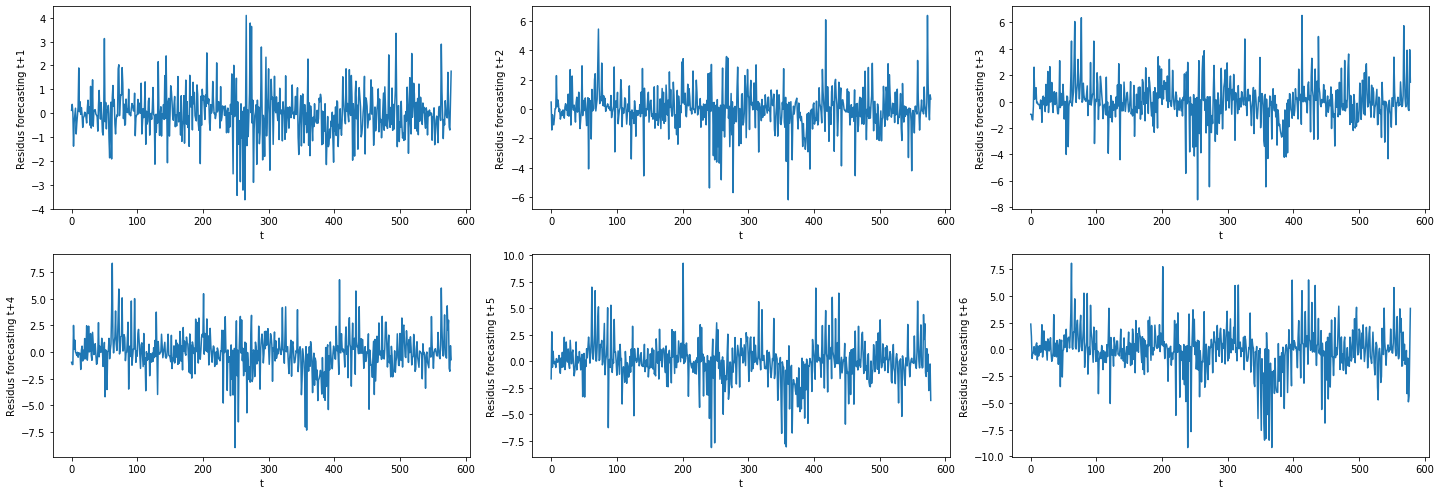

In [36]:
predict_train_rf = regressor_rf_chain.predict(X_train)
residus_rf = (y_train - predict_train_rf)

t = [i for i in range(0,len(residus_rf['DO_t+1']))]
#print(t)
plt.subplots(figsize=(20,10))
plt.subplot(3, 3, 1)
plt.plot(t, residus_rf['DO_t+1']) 
plt.ylabel('Residus forecasting t+1')
plt.xlabel('t')
plt.subplot(3, 3, 2)
plt.plot(t, residus_rf['DO_t+2']) 
plt.ylabel('Residus forecasting t+2')
plt.xlabel('t')
plt.subplot(3, 3, 3)
plt.plot(t, residus_rf['DO_t+3']) 
plt.ylabel('Residus forecasting t+3')
plt.xlabel('t')
plt.subplot(3, 3, 4)
plt.plot(t, residus_rf['DO_t+4']) 
plt.ylabel('Residus forecasting t+4')
plt.xlabel('t')
plt.subplot(3, 3, 5)
plt.plot(t, residus_rf['DO_t+5']) 
plt.ylabel('Residus forecasting t+5')
plt.xlabel('t')
plt.subplot(3, 3, 6)
plt.plot(t, residus_rf['DO_t+6']) 
plt.ylabel('Residus forecasting t+6')
plt.xlabel('t')
plt.tight_layout()
plt.show()


### Quatrième modèle : Modèle par device

La tentative de la prochaine méthode consiste à calculer un estimateur pour chacun des appareils directement. Il est probable que le problème avec les méthodes précédentes est qu'il est trop difficile de faire un modèle général qui englobe tous les appareils. Etant donné que le nombre d'observations par appareil est d'environ 200, il n'est pas raisonnable d'utiliser une méthode trop complexe. Nous allons donc considérer les régressions linéaires et les régressions lasso (permettant de faire une sélection de variables également) combiné avec RegressorChain pour injecter les prévisions.

In [37]:
## création des jeux de données pour chaque device

X_1 = Data_DO_Lag_1[['WaterTemperature', 'weather_temperature', 'dewpoint', 'humidity', 
                    'windspeed', 'winddirection', 'hour', 'DO_t', 'DO_t_1', 'DO_t_2', 'DO_t_3', 
                    'DO_t_5',  'DO_t_6', 'DO_t_8', 'DO_t_9', 'DO_t_10', 'DO_t_11', 'DO_t_12', 'DO_t_13', 
                    'DO_t_15', 'DO_t_16', 'DO_t_19', 'DO_t_20', 'DO_t_21', 'DO_t_22', 'DO_t_23', 'DO_t_25', 
                    'DO_t_26', 'DO_t_30', 'DO_t_31', 'DO_t_32', 'DO_t_37', 'DO_t_38', 'DO_t_41', 'DO_t_44', 
                    'DO_t_45', 'DO_t_47']]

y_1 = Data_DO_Lag_1[['DO_t+1', 'DO_t+2', 'DO_t+3', 'DO_t+4', 'DO_t+5', 'DO_t+6']]
#séparation train/test set
X_1_train = X_1[:int(X_1.shape[0]*0.7)]
X_1_test = X_1[int(X_1.shape[0]*0.7):]
y_1_train = y_1[:int(X_1.shape[0]*0.7)]
y_1_test = y_1[int(X_1.shape[0]*0.7):]

X_2 = Data_DO_Lag_2[['WaterTemperature', 'weather_temperature', 'dewpoint', 'humidity', 
                    'windspeed', 'winddirection', 'hour', 'DO_t', 'DO_t_1', 'DO_t_2', 'DO_t_3', 
                    'DO_t_5',  'DO_t_6', 'DO_t_8', 'DO_t_9', 'DO_t_10', 'DO_t_11', 'DO_t_12', 'DO_t_13', 
                    'DO_t_15', 'DO_t_16', 'DO_t_19', 'DO_t_20', 'DO_t_21', 'DO_t_22', 'DO_t_23', 'DO_t_25', 
                    'DO_t_26', 'DO_t_30', 'DO_t_31', 'DO_t_32', 'DO_t_37', 'DO_t_38', 'DO_t_41', 'DO_t_44', 
                    'DO_t_45', 'DO_t_47']]

y_2 = Data_DO_Lag_2[['DO_t+1', 'DO_t+2', 'DO_t+3', 'DO_t+4', 'DO_t+5', 'DO_t+6']]
#séparation train/test set
X_2_train = X_2[:int(X_2.shape[0]*0.7)]
X_2_test = X_2[int(X_2.shape[0]*0.7):]
y_2_train = y_2[:int(X_2.shape[0]*0.7)]
y_2_test = y_2[int(X_2.shape[0]*0.7):]

X_3 = Data_DO_Lag_3[['WaterTemperature', 'weather_temperature', 'dewpoint', 'humidity', 
                    'windspeed', 'winddirection', 'hour', 'DO_t', 'DO_t_1', 'DO_t_2', 'DO_t_3', 
                    'DO_t_5',  'DO_t_6', 'DO_t_8', 'DO_t_9', 'DO_t_10', 'DO_t_11', 'DO_t_12', 'DO_t_13', 
                    'DO_t_15', 'DO_t_16', 'DO_t_19', 'DO_t_20', 'DO_t_21', 'DO_t_22', 'DO_t_23', 'DO_t_25', 
                    'DO_t_26', 'DO_t_30', 'DO_t_31', 'DO_t_32', 'DO_t_37', 'DO_t_38', 'DO_t_41', 'DO_t_44', 
                    'DO_t_45', 'DO_t_47']]

y_3 = Data_DO_Lag_3[['DO_t+1', 'DO_t+2', 'DO_t+3', 'DO_t+4', 'DO_t+5', 'DO_t+6']]
#séparation train/test set
X_3_train = X_3[:int(X_3.shape[0]*0.7)]
X_3_test = X_3[int(X_3.shape[0]*0.7):]
y_3_train = y_3[:int(X_3.shape[0]*0.7)]
y_3_test = y_3[int(X_3.shape[0]*0.7):]

X_4 = Data_DO_Lag_4[['WaterTemperature', 'weather_temperature', 'dewpoint', 'humidity', 
                    'windspeed', 'winddirection', 'hour', 'DO_t', 'DO_t_1', 'DO_t_2', 'DO_t_3', 
                    'DO_t_5',  'DO_t_6', 'DO_t_8', 'DO_t_9', 'DO_t_10', 'DO_t_11', 'DO_t_12', 'DO_t_13', 
                    'DO_t_15', 'DO_t_16', 'DO_t_19', 'DO_t_20', 'DO_t_21', 'DO_t_22', 'DO_t_23', 'DO_t_25', 
                    'DO_t_26', 'DO_t_30', 'DO_t_31', 'DO_t_32', 'DO_t_37', 'DO_t_38', 'DO_t_41', 'DO_t_44', 
                    'DO_t_45', 'DO_t_47']]

y_4 = Data_DO_Lag_4[['DO_t+1', 'DO_t+2', 'DO_t+3', 'DO_t+4', 'DO_t+5', 'DO_t+6']]
#séparation train/test set
X_4_train = X_4[:int(X_4.shape[0]*0.7)]
X_4_test = X_4[int(X_4.shape[0]*0.7):]
y_4_train = y_4[:int(X_4.shape[0]*0.7)]
y_4_test = y_4[int(X_4.shape[0]*0.7):]

X_5 = Data_DO_Lag_5[['WaterTemperature', 'weather_temperature', 'dewpoint', 'humidity', 
                    'windspeed', 'winddirection', 'hour', 'DO_t', 'DO_t_1', 'DO_t_2', 'DO_t_3', 
                    'DO_t_5',  'DO_t_6', 'DO_t_8', 'DO_t_9', 'DO_t_10', 'DO_t_11', 'DO_t_12', 'DO_t_13', 
                    'DO_t_15', 'DO_t_16', 'DO_t_19', 'DO_t_20', 'DO_t_21', 'DO_t_22', 'DO_t_23', 'DO_t_25', 
                    'DO_t_26', 'DO_t_30', 'DO_t_31', 'DO_t_32', 'DO_t_37', 'DO_t_38', 'DO_t_41', 'DO_t_44', 
                    'DO_t_45', 'DO_t_47']]

y_5 = Data_DO_Lag_5[['DO_t+1', 'DO_t+2', 'DO_t+3', 'DO_t+4', 'DO_t+5', 'DO_t+6']]
#séparation train/test set
X_5_train = X_5[:int(X_5.shape[0]*0.7)]
X_5_test = X_5[int(X_5.shape[0]*0.7):]
y_5_train = y_5[:int(X_5.shape[0]*0.7)]
y_5_test = y_5[int(X_5.shape[0]*0.7):]

Pour faire fonctionner au mieux ce type d'algorithme il faut rescale les valeurs d'entrée.

In [38]:
normalizer_1 = preprocessing.Normalizer()
normalized_X_1_train = pd.DataFrame(normalizer_1.fit_transform(X_1_train))
normalized_X_1_test = pd.DataFrame(normalizer_1.transform(X_1_test))

normalizer_2 = preprocessing.Normalizer()
normalized_X_2_train = pd.DataFrame(normalizer_2.fit_transform(X_2_train))
normalized_X_2_test = pd.DataFrame(normalizer_2.transform(X_2_test))

normalizer_3 = preprocessing.Normalizer()
normalized_X_3_train = pd.DataFrame(normalizer_3.fit_transform(X_3_train))
normalized_X_3_test = pd.DataFrame(normalizer_3.transform(X_3_test))

normalizer_4 = preprocessing.Normalizer()
normalized_X_4_train = pd.DataFrame(normalizer_4.fit_transform(X_4_train))
normalized_X_4_test = pd.DataFrame(normalizer_4.transform(X_4_test))

normalizer_5 = preprocessing.Normalizer()
normalized_X_5_train = pd.DataFrame(normalizer_5.fit_transform(X_5_train))
normalized_X_5_test = pd.DataFrame(normalizer_5.transform(X_5_test))

#print(normalized_X_5_train)

#### Régressions linéaires

In [39]:
def standard_regression(normalized_data_train, y_train, normalized_data_test, y_test, w):
    linear_reg = RegressorChain(LinearRegression())
    # fit the regressor with x and y data 
    linear_reg.fit(normalized_data_train, y_train)   
    predict_linear_reg = linear_reg.predict(normalized_data_test)
    mse_linear_reg =  mean_squared_error(y_test, predict_linear_reg,  multioutput='raw_values')
    mae_linear_reg = mean_absolute_error(y_test, predict_linear_reg,  multioutput='raw_values')
    print("Erreur mse sur le test set pour device ", w ," :", mse_linear_reg)
    print("Erreur mae sur le test set pour device ", w ," :", mae_linear_reg)

In [40]:
standard_regression(normalized_X_1_train, y_1_train, normalized_X_1_test, y_1_test,1)
standard_regression(normalized_X_2_train, y_2_train, normalized_X_2_test, y_2_test,2)
standard_regression(normalized_X_3_train, y_3_train, normalized_X_3_test, y_3_test,3)
standard_regression(normalized_X_4_train, y_4_train, normalized_X_4_test, y_4_test,4)
standard_regression(normalized_X_5_train, y_5_train, normalized_X_5_test, y_5_test,5)

Erreur mse sur le test set pour device  1  : [ 30.70228619  80.11925531 118.92470155 336.05654111 267.61851928
 181.47804581]
Erreur mae sur le test set pour device  1  : [ 4.50418757  7.10814255  8.707273   14.51130175 13.0075471  10.56938482]
Erreur mse sur le test set pour device  2  : [172.39589871 521.37378701 674.15813248 479.29874719 613.7544376
 767.23102082]
Erreur mae sur le test set pour device  2  : [10.52447412 19.27709322 22.14155644 18.53115898 20.86810066 23.07868421]
Erreur mse sur le test set pour device  3  : [13.82943125 16.15162275 10.9207464   7.42687696  6.54869339  7.11788487]
Erreur mae sur le test set pour device  3  : [3.18483194 3.30465315 2.55424434 2.14909928 2.0566114  2.07760813]
Erreur mse sur le test set pour device  4  : [18.584349   43.68979872 57.15745173 49.29759919 40.72071719 46.01534657]
Erreur mae sur le test set pour device  4  : [3.39953488 5.50141856 6.57271442 6.01177457 5.43881294 5.88644458]
Erreur mse sur le test set pour device  5  : [1

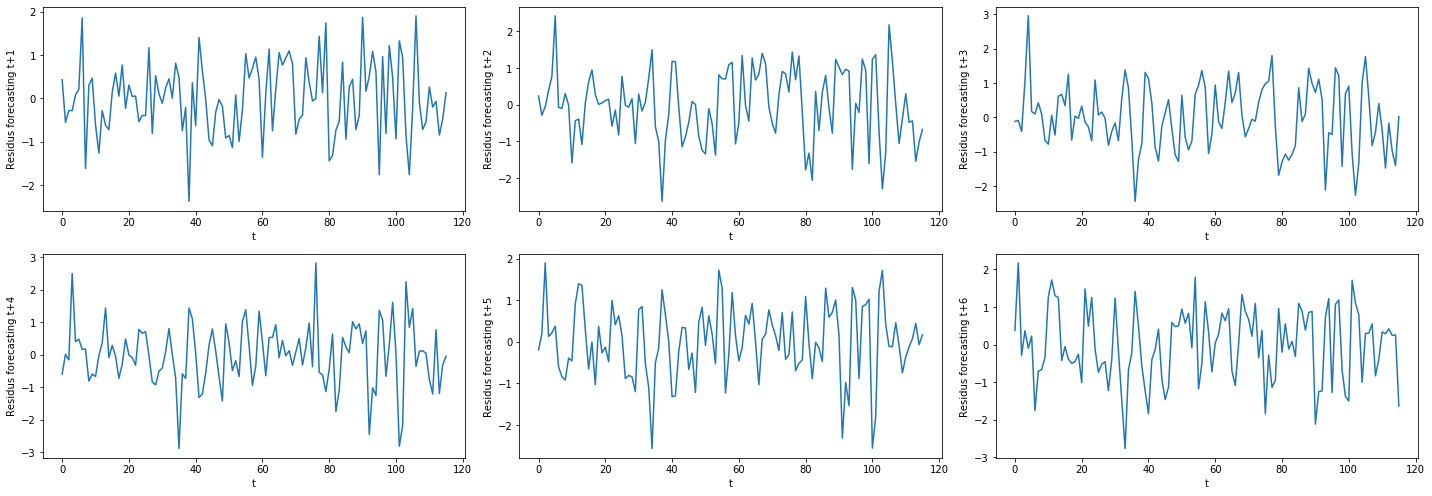

In [41]:
linear_reg = RegressorChain(LinearRegression())
linear_reg.fit(normalized_X_3_train, y_3_train)
predict_train_linear = linear_reg.predict(normalized_X_3_train)
residus_linear = (y_3_train - predict_train_linear)

t = [i for i in range(0,len(residus_linear['DO_t+1']))]
#print(t)
plt.subplots(figsize=(20,10))
plt.subplot(3, 3, 1)
plt.plot(t, residus_linear['DO_t+1']) 
plt.ylabel('Residus forecasting t+1')
plt.xlabel('t')
plt.subplot(3, 3, 2)
plt.plot(t, residus_linear['DO_t+2']) 
plt.ylabel('Residus forecasting t+2')
plt.xlabel('t')
plt.subplot(3, 3, 3)
plt.plot(t, residus_linear['DO_t+3']) 
plt.ylabel('Residus forecasting t+3')
plt.xlabel('t')
plt.subplot(3, 3, 4)
plt.plot(t, residus_linear['DO_t+4']) 
plt.ylabel('Residus forecasting t+4')
plt.xlabel('t')
plt.subplot(3, 3, 5)
plt.plot(t, residus_linear['DO_t+5']) 
plt.ylabel('Residus forecasting t+5')
plt.xlabel('t')
plt.subplot(3, 3, 6)
plt.plot(t, residus_linear['DO_t+6']) 
plt.ylabel('Residus forecasting t+6')
plt.xlabel('t')
plt.tight_layout()
plt.show()

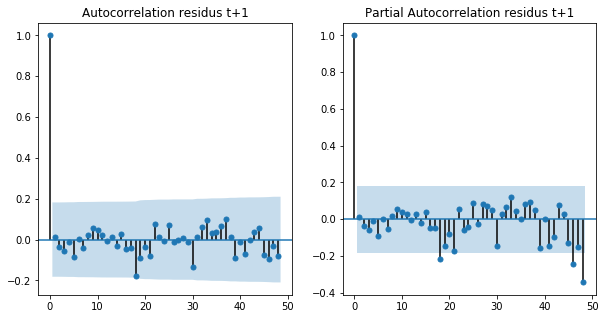

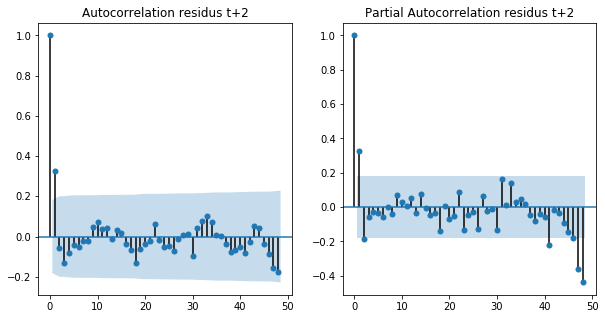

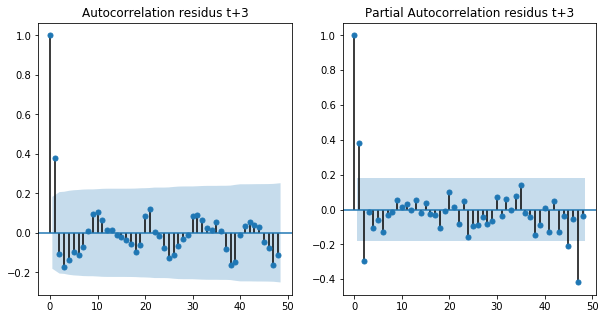

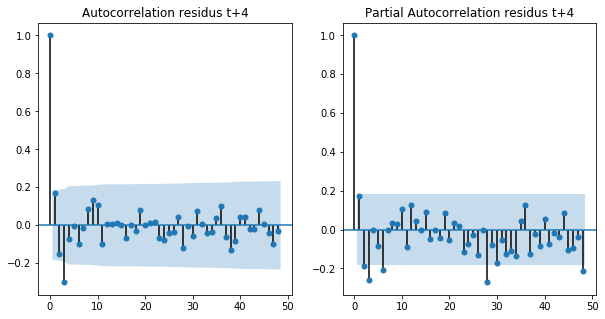

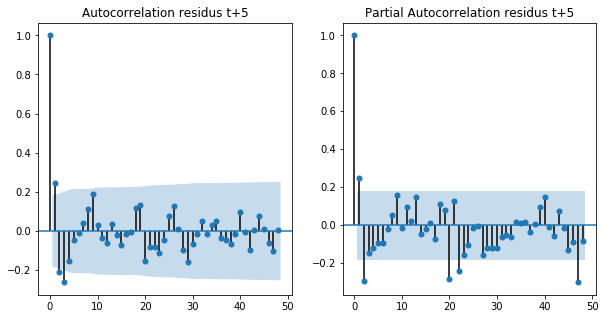

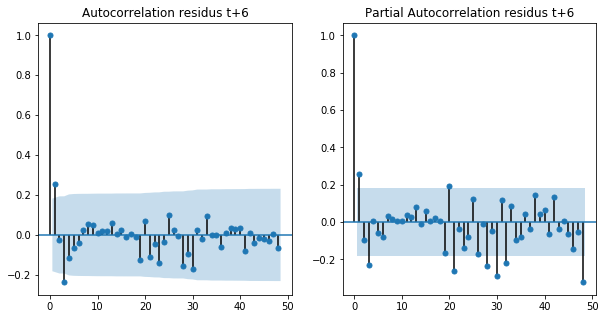

In [42]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(residus_linear['DO_t+1'], lags=48, ax=ax[0], title='Autocorrelation residus t+1');
plot_pacf(residus_linear['DO_t+1'], lags=48, ax=ax[1], title='Partial Autocorrelation residus t+1');

fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(residus_linear['DO_t+2'], lags=48, ax=ax[0], title='Autocorrelation residus t+2');
plot_pacf(residus_linear['DO_t+2'], lags=48, ax=ax[1], title='Partial Autocorrelation residus t+2');

fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(residus_linear['DO_t+3'], lags=48, ax=ax[0], title='Autocorrelation residus t+3');
plot_pacf(residus_linear['DO_t+3'], lags=48, ax=ax[1], title='Partial Autocorrelation residus t+3');

fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(residus_linear['DO_t+4'], lags=48, ax=ax[0], title='Autocorrelation residus t+4');
plot_pacf(residus_linear['DO_t+4'], lags=48, ax=ax[1], title='Partial Autocorrelation residus t+4');

fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(residus_linear['DO_t+5'], lags=48, ax=ax[0], title='Autocorrelation residus t+5');
plot_pacf(residus_linear['DO_t+5'], lags=48, ax=ax[1], title='Partial Autocorrelation residus t+5');

fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(residus_linear['DO_t+6'], lags=48, ax=ax[0], title='Autocorrelation residus t+6');
plot_pacf(residus_linear['DO_t+6'], lags=48, ax=ax[1], title='Partial Autocorrelation residus t+6');

En ajustant une régression standard pour chaque device nous remarquons deux opposés. Pour les deux premiers device, quel que soit l'horizon de prévision, nous faisons moins bien qu'avec les méthodes précédentes. Cependant, les trois autres, nous faisons un peu moins bien en prévision à t+1. Par contre, les performances sont clairement meilleures pour les prévisions pour t+2 à t+6, en particulier pour le device 3 où les performances plus lointaines sont même meilleures que la performance en t+1. Nous observons cependant qu'il reste des autocorrélations non-expliquées dans les résidus.

#### Régressions Lasso

Nous essayons maintenant la régression Lasso. Le paramètre fondamental dans la régression Lasso est lambda, le paramètre qui gère à quel point la pénalité L1 est pondérée. Un grand lambda entraîne une mise à 0 de beaucoup des coefficients de régression, inversement lambda = 0 correspond à la regression classique. Nous utilisons la même validation croisée temporelle que précédemment. La grille de lambda va de 1 (ici aller en dessous ne permet pas de converger) à lambda_max (qui dépend du device) et est calculée à partir de la formule donnée dans "Regularization Paths for Generalized Linear Modelsvia Coordinate Descent" par J. Friedman, T. Hastie et R. Tibshirani.

In [43]:
lambda_1_max = max([max(p)/len(normalized_X_1_train) for p in abs(np.dot(np.transpose(y_1_train), normalized_X_1_train))])
lambda_2_max = max([max(p)/len(normalized_X_2_train) for p in abs(np.dot(np.transpose(y_2_train), normalized_X_2_train))])
lambda_3_max = max([max(p)/len(normalized_X_3_train) for p in abs(np.dot(np.transpose(y_3_train), normalized_X_3_train))])
lambda_4_max = max([max(p)/len(normalized_X_4_train) for p in abs(np.dot(np.transpose(y_4_train), normalized_X_4_train))])
lambda_5_max = max([max(p)/len(normalized_X_5_train) for p in abs(np.dot(np.transpose(y_5_train), normalized_X_5_train))])
#print(len(range_alpha))

In [44]:
param_grid_1 = {
                 'alpha': np.arange(1, lambda_1_max, 0.05)
             }

# 5-Fold Cross validation Time series version
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score_1 = []
for tr_index, val_index in tscv.split(normalized_X_1_train):
    #print(tr_index, val_index)
    X_tr, X_val = normalized_X_1_train.iloc[tr_index], normalized_X_1_train.iloc[val_index]
    y_tr, y_val = y_1_train.iloc[tr_index], y_1_train.iloc[val_index]
    for al in param_grid_1['alpha']:
        lasso_al = RegressorChain(Lasso(alpha=int(al)))
        lasso_al.fit(X_tr, y_tr)
        predict_lasso = lasso_al.predict(X_val)
        score_1.append([i,
                      al, 
                      mean_squared_error(y_val, predict_lasso,  multioutput='raw_values'),
                      mean_absolute_error(y_val, predict_lasso,  multioutput='raw_values')])
    i += 1

In [45]:
param_grid_2 = {
                 'alpha': np.arange(1, lambda_2_max, 0.05)
             }

# 5-Fold Cross validation Time series version
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score_2 = []
for tr_index, val_index in tscv.split(normalized_X_2_train):
    #print(tr_index, val_index)
    X_tr, X_val = normalized_X_2_train.iloc[tr_index], normalized_X_2_train.iloc[val_index]
    y_tr, y_val = y_2_train.iloc[tr_index], y_2_train.iloc[val_index]
    for al in param_grid_2['alpha']:
        lasso_al = RegressorChain(Lasso(alpha=int(al)))
        lasso_al.fit(X_tr, y_tr)
        predict_lasso = lasso_al.predict(X_val)
        score_2.append([i,
                      al, 
                      mean_squared_error(y_val, predict_lasso,  multioutput='raw_values'),
                      mean_absolute_error(y_val, predict_lasso,  multioutput='raw_values')])
    i += 1

In [46]:
param_grid_3 = {
                 'alpha': np.arange(1, lambda_3_max, 0.05)
             }

# 5-Fold Cross validation Time series version
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score_3 = []
for tr_index, val_index in tscv.split(normalized_X_3_train):
    #print(tr_index, val_index)
    X_tr, X_val = normalized_X_3_train.iloc[tr_index], normalized_X_3_train.iloc[val_index]
    y_tr, y_val = y_3_train.iloc[tr_index], y_3_train.iloc[val_index]
    for al in param_grid_3['alpha']:
        lasso_al = RegressorChain(Lasso(alpha=int(al)))
        lasso_al.fit(X_tr, y_tr)
        predict_lasso = lasso_al.predict(X_val)
        score_3.append([i,
                      al, 
                      mean_squared_error(y_val, predict_lasso,  multioutput='raw_values'),
                      mean_absolute_error(y_val, predict_lasso,  multioutput='raw_values')])
    i += 1

In [47]:
param_grid_4 = {
                 'alpha': np.arange(1, lambda_4_max, 0.05)
             }

# 5-Fold Cross validation Time series version
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score_4 = []
for tr_index, val_index in tscv.split(normalized_X_4_train):
    #print(tr_index, val_index)
    X_tr, X_val = normalized_X_4_train.iloc[tr_index], normalized_X_4_train.iloc[val_index]
    y_tr, y_val = y_4_train.iloc[tr_index], y_4_train.iloc[val_index]
    for al in param_grid_4['alpha']:
        lasso_al = RegressorChain(Lasso(alpha=int(al)))
        lasso_al.fit(X_tr, y_tr)
        predict_lasso = lasso_al.predict(X_val)
        score_4.append([i,
                      al, 
                      mean_squared_error(y_val, predict_lasso,  multioutput='raw_values'),
                      mean_absolute_error(y_val, predict_lasso,  multioutput='raw_values')])
    i += 1

In [48]:
param_grid_5 = {
                 'alpha': np.arange(1, lambda_5_max, 0.05)
             }

# 5-Fold Cross validation Time series version
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score_5 = []
for tr_index, val_index in tscv.split(normalized_X_5_train):
    #print(tr_index, val_index)
    X_tr, X_val = normalized_X_5_train.iloc[tr_index], normalized_X_5_train.iloc[val_index]
    y_tr, y_val = y_5_train.iloc[tr_index], y_5_train.iloc[val_index]
    for al in param_grid_5['alpha']:
        lasso_al = RegressorChain(Lasso(alpha=int(al)))
        lasso_al.fit(X_tr, y_tr)
        predict_lasso = lasso_al.predict(X_val)
        score_5.append([i,
                      al, 
                      mean_squared_error(y_val, predict_lasso,  multioutput='raw_values'),
                      mean_absolute_error(y_val, predict_lasso,  multioutput='raw_values')])
    i += 1

In [49]:
def best_param_al(score_list, w, param_grid):
    score_average_mse = list()
    score_average_mae = list()
    for al in param_grid['alpha']:
        for i in range(len(score_list)):
            temp_score = score_list[i]
            if temp_score[1]==al:
                score_mean_mse = mean(temp_score[2])
                score_mean_mae = mean(temp_score[3])
                get_score_mse.append(score_mean_mse)
                get_score_mae.append(score_mean_mae)
        score_average_mse.append([al, mean(get_score_mse)])
        score_average_mae.append([al, mean(get_score_mae)])
        #print(score[0][3])

    min_param_mse_index = 0
    current_best_mse = score_average_mse[0][1]
    min_param_mae_index = 0
    current_best_mae = score_average_mae[0][1]
    for u in score_average_mse:
        if u[1] < current_best_mse:
            min_param_mse_index = score_average_mse.index(u)
            current_best_mse = u[1]
    for u in score_average_mae:        
        if u[1] < current_best_mae:
            min_param_mae_index = score_average_mae.index(u)
            current_best_mae = u[1]

    print("Meilleur paramètre pour le critère mse. Alpha optimal pour device ", w ," :", round(score_average_mse[min_param_mse_index][0],2))
    print("Meilleur paramètre pour le critère mae. Alpha optimal pour device ", w ," :", round(score_average_mae[min_param_mae_index][0],2))



In [50]:
best_param_al(score_1,1,param_grid_1)
best_param_al(score_2,2,param_grid_2)
best_param_al(score_3,3,param_grid_3)
best_param_al(score_4,4,param_grid_4)
best_param_al(score_5,5,param_grid_5)

Meilleur paramètre pour le critère mse. Alpha optimal pour device  1  : 1.0
Meilleur paramètre pour le critère mae. Alpha optimal pour device  1  : 1.0
Meilleur paramètre pour le critère mse. Alpha optimal pour device  2  : 39.75
Meilleur paramètre pour le critère mae. Alpha optimal pour device  2  : 39.75
Meilleur paramètre pour le critère mse. Alpha optimal pour device  3  : 36.4
Meilleur paramètre pour le critère mae. Alpha optimal pour device  3  : 36.4
Meilleur paramètre pour le critère mse. Alpha optimal pour device  4  : 36.05
Meilleur paramètre pour le critère mae. Alpha optimal pour device  4  : 36.05
Meilleur paramètre pour le critère mse. Alpha optimal pour device  5  : 36.35
Meilleur paramètre pour le critère mae. Alpha optimal pour device  5  : 36.35


In [51]:
def lasso_alpha_best(alpha_best, normalized_data_train, y_train, normalized_data_test, y_test, w):
    lasso_alpha_best = RegressorChain(Lasso(alpha=alpha_best))
    # fit the regressor with x and y data 
    lasso_alpha_best.fit(normalized_data_train, y_train)   
    predict_alpha_best = lasso_alpha_best.predict(normalized_data_test)
    mse_alpha_best =  mean_squared_error(y_test, predict_alpha_best,  multioutput='raw_values')
    mae_alpha_best = mean_absolute_error(y_test, predict_alpha_best,  multioutput='raw_values')
    print("Erreur mse sur le test set pour device ", w ," :", mse_alpha_best)
    print("Erreur mae sur le test set pour device ", w ," :", mae_alpha_best)

In [52]:
lasso_alpha_best(1,normalized_X_1_train, y_1_train, normalized_X_1_test, y_1_test,1)
lasso_alpha_best(39.75,normalized_X_2_train, y_2_train, normalized_X_2_test, y_2_test,2)
lasso_alpha_best(36.4,normalized_X_3_train, y_3_train, normalized_X_3_test, y_3_test,3)
lasso_alpha_best(36.05,normalized_X_4_train, y_4_train, normalized_X_4_test, y_4_test,4)
lasso_alpha_best(36.35,normalized_X_5_train, y_5_train, normalized_X_5_test, y_5_test,5)

Erreur mse sur le test set pour device  1  : [53.34140995 63.46022578 71.80974191 80.24545905 87.75592068 97.54525486]
Erreur mae sur le test set pour device  1  : [5.88599643 6.31973369 6.61622388 6.93746177 7.22826516 7.59646853]
Erreur mse sur le test set pour device  2  : [18.21760109 22.49897581 25.25497817 29.19922608 35.33277619 42.60185835]
Erreur mae sur le test set pour device  2  : [3.56347222 3.82519444 4.04665467 4.32909217 4.62673169 4.91256376]
Erreur mse sur le test set pour device  3  : [10.0464423  10.69492251 10.97405681 11.11944275 11.3114483  11.53453855]
Erreur mae sur le test set pour device  3  : [2.65711601 2.75124887 2.80961094 2.85971631 2.91364802 2.94219997]
Erreur mse sur le test set pour device  4  : [24.01395435 25.52773636 27.57135817 30.21940009 31.99209422 33.2817468 ]
Erreur mae sur le test set pour device  4  : [3.91152009 4.08321976 4.27265814 4.51380217 4.70660949 4.85745777]
Erreur mse sur le test set pour device  5  : [41.81854343 43.49548897 44

Ici, il est très clair que les performances sont moins bonnes que les méthodes précédentes excepté pour le device 3. Il serait intéressant de voir combien de variables ont des coefficients non nuls.

In [53]:
def non_nul_variables(alpha, normalized_X_train, y_train):
    lasso_alpha_best = RegressorChain(Lasso(alpha=alpha))
    lasso_alpha_best.fit(normalized_X_train, y_train) 
    coeff_non_nul = []
    for estim_ in range(6):
        coeff_temp_non_nul = lasso_alpha_best.estimators_[estim_].coef_.tolist()
        non_nul = [i for i in range(len(coeff_temp_non_nul)) if abs(coeff_temp_non_nul[i])>0]
        coeff_non_nul.extend(non_nul)
    return coeff_non_nul

In [54]:
print("Variables ayant des coeffients non nuls pour device 1 :" ,np.unique(non_nul_variables(1, normalized_X_1_train, y_1_train)))
print("Variables ayant des coeffients non nuls pour device 2 :" ,np.unique(non_nul_variables(39.75, normalized_X_2_train, y_2_train)))
print("Variables ayant des coeffients non nuls pour device 3 :" ,np.unique(non_nul_variables(36.4, normalized_X_3_train, y_3_train)))
print("Variables ayant des coeffients non nuls pour device 4 :" ,np.unique(non_nul_variables(36.05, normalized_X_4_train, y_4_train)))
print("Variables ayant des coeffients non nuls pour device 5 :" ,np.unique(non_nul_variables(36.35, normalized_X_5_train, y_5_train)))

Variables ayant des coeffients non nuls pour device 1 : [37 38 39 40 41]
Variables ayant des coeffients non nuls pour device 2 : []
Variables ayant des coeffients non nuls pour device 3 : []
Variables ayant des coeffients non nuls pour device 4 : []
Variables ayant des coeffients non nuls pour device 5 : []


La première chose que nous remarquons est que seul le premier device a des coefficients non nuls, c'est-à-dire que qu'à part elle, la régression lasso considère ici que la meilleure solution est de prédire par l'intercept, c'est-à-dire par la moyenne de l'oxygène dissous. Il s'avère que ceci est évidemment mauvais au vu des performances. Le premier device donne cependant 5 coefficients non nuls, correspondant aux prévisions qui sont injectées pour prévoir les instants suivants et confirme d'une certaine manière ce que l'on a trouvé avec la dernière forêt aléatoire. 

En conclusion, les régressions linéaires sans pénalité semblent mieux fonctionner que les régressions Lasso ici, mais surtout fonctionnent bien mieux (pour les devices 3,4 et 5) pour les prévisions supérieurs à t+1 comparées aux forêts aléatoires. Cependant, en regardant les coefficients, aucune variable ne semble sortir du lot et n'avons pas d'informations supplémentaires sur les variables primordiales à la prévision. 

### Cinquième modèle : Retour aux forêts, élagage des variables moins brutal

Jusqu'ici, nous avons vu que pour les forêts "enchainées" et pour la régression Lasso sur le premier device, l'information utile pour la prévision est directement donnée par les trois dernières observations (ou prévisions). Ceci était fait en faisant une analyse des autocorrélations entre les lags sur l'oxygène dissous et voir les lags à priori utiles. Cette fois nous allons plus loin, étant donné que nous nous intéressons à prévoir les heures t+1, ... t+6 à partir d'une fenêtre de 48h, nous allons prendre tous les lags dans cette fenêtre. Ensuite, nous allons refaire un élagage des variables en utilisant l'importance des variables, mais de manière récursive. Ici l'objectif de prévision passe en second plan, ici nous cherchons à savoir s'il n'est pas possible de capturer des variables qui sont importantes qui seraient passées inaperçu jusqu'ici.

In [55]:
lags_considered = [i for i in range(1,48)]
#Augmentation des données par les lags 
data_device_1 = data_sorted[data_sorted["device"]=='device 1']
data_device_2 = data_sorted[data_sorted["device"]=='device 2']
data_device_3 = data_sorted[data_sorted["device"]=='device 3']
data_device_4 = data_sorted[data_sorted["device"]=='device 4']
data_device_5 = data_sorted[data_sorted["device"]=='device 5']

dissolved_ox_1 = data_device_1["DissolvedOxygen"]
dissolved_ox_2 = data_device_2["DissolvedOxygen"]
dissolved_ox_3 = data_device_3["DissolvedOxygen"]
dissolved_ox_4 = data_device_4["DissolvedOxygen"]
dissolved_ox_5 = data_device_5["DissolvedOxygen"]
Data_DO_Lag_1 = pd.DataFrame(dissolved_ox_1)
Data_DO_Lag_2 = pd.DataFrame(dissolved_ox_2)
Data_DO_Lag_3 = pd.DataFrame(dissolved_ox_3)
Data_DO_Lag_4 = pd.DataFrame(dissolved_ox_4)
Data_DO_Lag_5 = pd.DataFrame(dissolved_ox_5)
lags_name = ['DO_t']
for lag in lags_considered :
    Data_DO_Lag_1 = pd.concat([Data_DO_Lag_1, dissolved_ox_1.shift(lag) ], axis=1)
    Data_DO_Lag_2 = pd.concat([Data_DO_Lag_2, dissolved_ox_2.shift(lag) ], axis=1)
    Data_DO_Lag_3 = pd.concat([Data_DO_Lag_3, dissolved_ox_3.shift(lag) ], axis=1)
    Data_DO_Lag_4 = pd.concat([Data_DO_Lag_4, dissolved_ox_4.shift(lag) ], axis=1)
    Data_DO_Lag_5 = pd.concat([Data_DO_Lag_5, dissolved_ox_5.shift(lag) ], axis=1)
    name_temp_lag = 'DO_t_'+str(lag)
    lags_name.append(name_temp_lag)

lags_forecast = [-1,-2,-3,-4,-5,-6]
for lag in lags_forecast:
    Data_DO_Lag_1 = pd.concat([ dissolved_ox_1.shift(lag), Data_DO_Lag_1 ], axis=1)
    Data_DO_Lag_2 = pd.concat([ dissolved_ox_2.shift(lag), Data_DO_Lag_2 ], axis=1)
    Data_DO_Lag_3 = pd.concat([ dissolved_ox_3.shift(lag), Data_DO_Lag_3 ], axis=1)
    Data_DO_Lag_4 = pd.concat([ dissolved_ox_4.shift(lag), Data_DO_Lag_4 ], axis=1)
    Data_DO_Lag_5 = pd.concat([ dissolved_ox_5.shift(lag), Data_DO_Lag_5 ], axis=1)
    name_temp_lag = 'DO_t+' + str(lag)[1:]
    lags_name.insert(0,name_temp_lag)
    
Data_DO_Lag_1.columns = lags_name
Data_DO_Lag_2.columns = lags_name
Data_DO_Lag_3.columns = lags_name
Data_DO_Lag_4.columns = lags_name
Data_DO_Lag_5.columns = lags_name
#On enlève les observations où on ne peut pas avoir de lags
Data_DO_Lag_1 = pd.concat([Data_DO_Lag_1, data_device_1], axis=1)
Data_DO_Lag_2 = pd.concat([Data_DO_Lag_2, data_device_2 ], axis=1)
Data_DO_Lag_3 = pd.concat([Data_DO_Lag_3, data_device_3 ], axis=1)
Data_DO_Lag_4 = pd.concat([Data_DO_Lag_4, data_device_4 ], axis=1)
Data_DO_Lag_5 = pd.concat([Data_DO_Lag_5, data_device_5 ], axis=1)
Data_DO_Lag_1 = Data_DO_Lag_1.drop(Data_DO_Lag_1.index[0:47])
Data_DO_Lag_1 = Data_DO_Lag_1.drop(Data_DO_Lag_1.index[-6:])
Data_DO_Lag_2 = Data_DO_Lag_2.drop(Data_DO_Lag_2.index[0:47])
Data_DO_Lag_2 = Data_DO_Lag_2.drop(Data_DO_Lag_2.index[-6:])
Data_DO_Lag_3 = Data_DO_Lag_3.drop(Data_DO_Lag_3.index[0:47])
Data_DO_Lag_3 = Data_DO_Lag_3.drop(Data_DO_Lag_3.index[-6:])
Data_DO_Lag_4 = Data_DO_Lag_4.drop(Data_DO_Lag_4.index[0:47])
Data_DO_Lag_4 = Data_DO_Lag_4.drop(Data_DO_Lag_4.index[-6:])
Data_DO_Lag_5 = Data_DO_Lag_5.drop(Data_DO_Lag_5.index[0:47])
Data_DO_Lag_5 = Data_DO_Lag_5.drop(Data_DO_Lag_5.index[-6:])
Data_DO_big = pd.concat([Data_DO_Lag_1, Data_DO_Lag_2, Data_DO_Lag_3, Data_DO_Lag_4, Data_DO_Lag_5], axis=0).sort_values(['Datetime', 'device'])

In [56]:
Data_DO_big= Data_DO_big.replace(to_replace=['device 1', 'device 2', 'device 3', 'device 4', 'device 5'], value=[1, 2,3,4,5])
Data_DO_big = Data_DO_big.replace(to_replace=['site A', 'site B'], value=[1, 2])
Data_DO_big["device"] = Data_DO_big["device"].astype('category')
Data_DO_big["site"] = Data_DO_big["site"].astype('category')
#Data_DO_big = Data_DO_big.drop(columns = ['Unnamed: 0','Datetime'])
#print(Data_DO_big)

X = Data_DO_big[['WaterTemperature', 'device', 'site','weather_temperature', 'dewpoint', 'humidity', 
                'windspeed', 'winddirection', 'hour', 'DO_t', 'DO_t_1', 'DO_t_2', 'DO_t_3', 'DO_t_4', 
                 'DO_t_5', 'DO_t_6', 'DO_t_7', 'DO_t_8', 'DO_t_9', 'DO_t_10', 'DO_t_11', 'DO_t_12',
                 'DO_t_13', 'DO_t_14', 'DO_t_15', 'DO_t_16', 'DO_t_17', 'DO_t_18', 'DO_t_19', 'DO_t_20', 
                 'DO_t_21', 'DO_t_22', 'DO_t_23', 'DO_t_24', 'DO_t_25', 'DO_t_26', 'DO_t_27', 'DO_t_28', 
                 'DO_t_29', 'DO_t_30', 'DO_t_31', 'DO_t_32', 'DO_t_33', 'DO_t_34', 'DO_t_35', 'DO_t_36', 
                 'DO_t_37', 'DO_t_38', 'DO_t_39', 'DO_t_40', 'DO_t_41', 'DO_t_42', 'DO_t_43', 'DO_t_44', 
                 'DO_t_45', 'DO_t_46', 'DO_t_47']]

y = Data_DO_big[['DO_t+1', 'DO_t+2', 'DO_t+3', 'DO_t+4', 'DO_t+5', 'DO_t+6']]
#séparation train/test set
X_train = X[:int(X.shape[0]*0.7)]
X_test = X[int(X.shape[0]*0.7):]
y_train = y[:int(X.shape[0]*0.7)]
y_test = y[int(X.shape[0]*0.7):]

In [57]:
print(np.shape(X_train))

(579, 57)


In [58]:
# create regressor object 
regressor_rf = RegressorChain(RandomForestRegressor(n_estimators = 200, max_features = 57, random_state = 0))
# fit the regressor with x and y data 
regressor_rf.fit(X_train, y_train) 
predict_rf = regressor_rf.predict(X_test)
print("Erreur mse sur le test set : ", mean_squared_error(y_test, predict_rf,  multioutput='raw_values'))
print("Erreur mae sur le test set : ", mean_absolute_error(y_test, predict_rf,  multioutput='raw_values'))


Erreur mse sur le test set :  [11.53452721 24.49102829 34.44076073 43.49335184 50.34480196 55.39812113]
Erreur mae sur le test set :  [2.61968333 3.79826161 4.52941693 4.94883199 5.30686934 5.52066928]


Ici, nous remarquons une très légère amélioration des performances par rapport à la troisième méthode mais l'objectif n'est plus le même. Ici, nous cherchons à modifier notre manière de sélectionner les variables et récupérer d'éventuelles variables importantes qui sont passées inaperçu jusqu'ici.

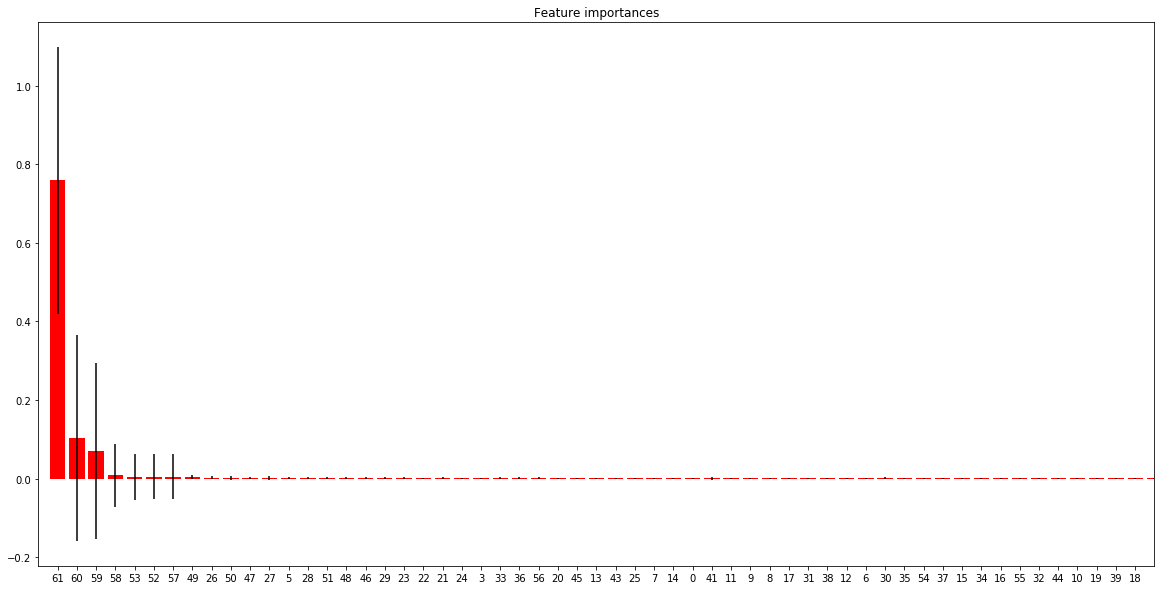

In [59]:
estim_ = 5
#print(regressor_rf.estimators_[estim_].feature_importances_)

#on garde les features > 1%
importances = regressor_rf.estimators_[estim_].feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor_rf.estimators_[estim_]],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(len(regressor_rf.estimators_[estim_].feature_importances_)), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Au lieu de supprimer la majorité des variables d'un seul coup, il faudrait peut-être supprimer par blocs (de 5 par exemple). Il se peut que certaines variables soient inutiles dues à la façon dont les arbres sont construits. En éliminant des blocs de variable de manière récursive, il se peut que certaines variables montrent une importance de plus en plus grande qu'on n'aurait pas observée précédemment. 

In [60]:
index_importance_low = []
for estim_ in range(6):
    importances = regressor_rf.estimators_[estim_].feature_importances_.tolist()
    importances_sort = sorted(importances)
    for u in importances_sort[:10]:
        index_temp = importances.index(u)
        index_importance_low.append(index_temp)

occurrence_low_imp = dict((x,index_importance_low.count(x)) for x in set(index_importance_low))
occ_sorted = sorted(occurrence_low_imp.items(), key=lambda x: x[1], reverse=True)
five_imp_low = [item[0] for item in occ_sorted[:5]]
print("Variables considérées les moins importantes :",X.columns[five_imp_low].tolist())

Variables considérées les moins importantes : ['device', 'site', 'DO_t_35', 'windspeed', 'dewpoint']


In [61]:
index_importance_high = []
for estim_ in range(6):
    importances = regressor_rf.estimators_[estim_].feature_importances_.tolist()
    importances_sort = sorted(importances, reverse=True)
    for u in importances_sort[:10]:
        index_temp = importances.index(u)
        index_importance_high.append(index_temp)

occurrence_high_imp = dict((x,index_importance_high.count(x)) for x in set(index_importance_high))
occ_high_sorted = sorted(occurrence_high_imp.items(), key=lambda x: x[1], reverse=True)
five_imp_top = [item[0] for item in occ_high_sorted[:10]]
five_imp_top_removed = [x for x in five_imp_top if x <= 56]
print("Variables considérées les plus importantes pour le moment :", X.columns[five_imp_top_removed].tolist())
#print(five_imp_top)

Variables considérées les plus importantes pour le moment : ['DO_t', 'DO_t_43', 'DO_t_44', 'DO_t_41', 'DO_t_42', 'hour', 'DO_t_1']


D'après la forêt précédente, les 5 variables qui se retrouvent le plus souvent dans les 10 dernières (en terme d'importance) sont : device, site, DO_t_35, windspeed, dewpoint. On les élimine, on construit une forêt sur la matrice réduite et on répète cela jusqu'à avoir un ensemble beaucoup plus réduit. 

On peut également noter les 7 variables les plus importantes pour le moment d'après la sortie précédente (sans prendre en compte les prévisions injectées) : DO_t, DO_t_43, DO_t_44, DO_t_41, DO_t_42, hour, DO_t_1.

In [62]:
to_drop = []
for i in range(0,11):
    X = Data_DO_big[['WaterTemperature', 'device', 'site','weather_temperature', 'dewpoint', 'humidity', 
                    'windspeed', 'winddirection', 'hour', 'DO_t', 'DO_t_1', 'DO_t_2', 'DO_t_3', 'DO_t_4', 
                     'DO_t_5', 'DO_t_6', 'DO_t_7', 'DO_t_8', 'DO_t_9', 'DO_t_10', 'DO_t_11', 'DO_t_12',
                     'DO_t_13', 'DO_t_14', 'DO_t_15', 'DO_t_16', 'DO_t_17', 'DO_t_18', 'DO_t_19', 'DO_t_20', 
                     'DO_t_21', 'DO_t_22', 'DO_t_23', 'DO_t_24', 'DO_t_25', 'DO_t_26', 'DO_t_27', 'DO_t_28', 
                     'DO_t_29', 'DO_t_30', 'DO_t_31', 'DO_t_32', 'DO_t_33', 'DO_t_34', 'DO_t_35', 'DO_t_36', 
                     'DO_t_37', 'DO_t_38', 'DO_t_39', 'DO_t_40', 'DO_t_41', 'DO_t_42', 'DO_t_43', 'DO_t_44', 
                     'DO_t_45', 'DO_t_46', 'DO_t_47']]

    X = X.drop(columns = to_drop)

    y = Data_DO_big[['DO_t+1', 'DO_t+2', 'DO_t+3', 'DO_t+4', 'DO_t+5', 'DO_t+6']]
    #séparation train/test set
    X_train = X[:int(X.shape[0]*0.7)]
    X_test = X[int(X.shape[0]*0.7):]
    y_train = y[:int(X.shape[0]*0.7)]
    y_test = y[int(X.shape[0]*0.7):]
    regressor_rf = RegressorChain(RandomForestRegressor(n_estimators = 200, max_features = 57-i*5, random_state = 0))
    # fit the regressor with x and y data 
    regressor_rf.fit(X_train, y_train) 
    predict_rf = regressor_rf.predict(X_test)
    
    index_importance_low = []
    for estim_ in range(6):
        importances = regressor_rf.estimators_[estim_].feature_importances_.tolist()
        importances_sort = sorted(importances)
        for u in importances_sort[:10]:
            index_temp = importances.index(u)
            index_importance_low.append(index_temp)

    occurrence_low_imp = dict((x,index_importance_low.count(x)) for x in set(index_importance_low))
    occ_sorted = sorted(occurrence_low_imp.items(), key=lambda x: x[1], reverse=True)
    five_imp_low = [item[0] for item in occ_sorted[:5]]
    to_drop_add = X.columns[five_imp_low].tolist()
    to_drop.extend(to_drop_add)
    #print(to_drop)



In [63]:
print("Erreur mse sur le test set : ", mean_squared_error(y_test, predict_rf,  multioutput='raw_values')) 
print("Erreur mae sur le test set : ", mean_absolute_error(y_test, predict_rf,  multioutput='raw_values')) 
print(np.shape(X_train))

Erreur mse sur le test set :  [10.31655225 22.864931   32.83998196 39.97131083 48.48360617 54.48494352]
Erreur mae sur le test set :  [2.45583815 3.6617665  4.38798939 4.72351506 5.1724748  5.48624716]
(579, 7)


In [64]:
index_importance_high = []
for estim_ in range(6):
    importances = regressor_rf.estimators_[estim_].feature_importances_.tolist()
    importances_sort = sorted(importances, reverse=True)
    for u in importances_sort:
        index_temp = importances.index(u)
        index_importance_high.append(index_temp)

occurrence_high_imp = dict((x,index_importance_high.count(x)) for x in set(index_importance_high))
occ_high_sorted = sorted(occurrence_high_imp.items(), key=lambda x: x[1], reverse=True)
five_imp_top = [item[0] for item in occ_high_sorted[:7]]
print("Variables considérées les plus importantes après l'élagage récursif :", X.columns[five_imp_top])

Variables considérées les plus importantes après l'élagage récursif : Index(['DO_t', 'DO_t_2', 'DO_t_20', 'DO_t_40', 'DO_t_41', 'DO_t_42',
       'DO_t_44'],
      dtype='object')


Après l'élagage récursif nous observons au final 3 mêmes variables importantes (sans compter les prévisions injectées). Les différences sont 'DO_t_1', 'DO_t_41', 'DO_t_43' et 'hour' qui ont été remplacé par 'DO_t_2', 'DO_t_20', 'DO_t_40', 'DO_t_42'. La variable qui est toujours "inutile" est l'heure alors que nous avons vu une tendance journalière claire. Cependant, il semble qu'en connaissant l'oxygène dissous des heures précédentes l'algorithme infère l'heure (et le device) sans problème. Nous remarquons aussi une petite amélioration de la performance sur le test set. Cependant, nous sommes toujours loins des performances obtenues en régression pour les prévisions t+2 et plus et avons toujours le même problème avec les résidus (figure ci-dessous).

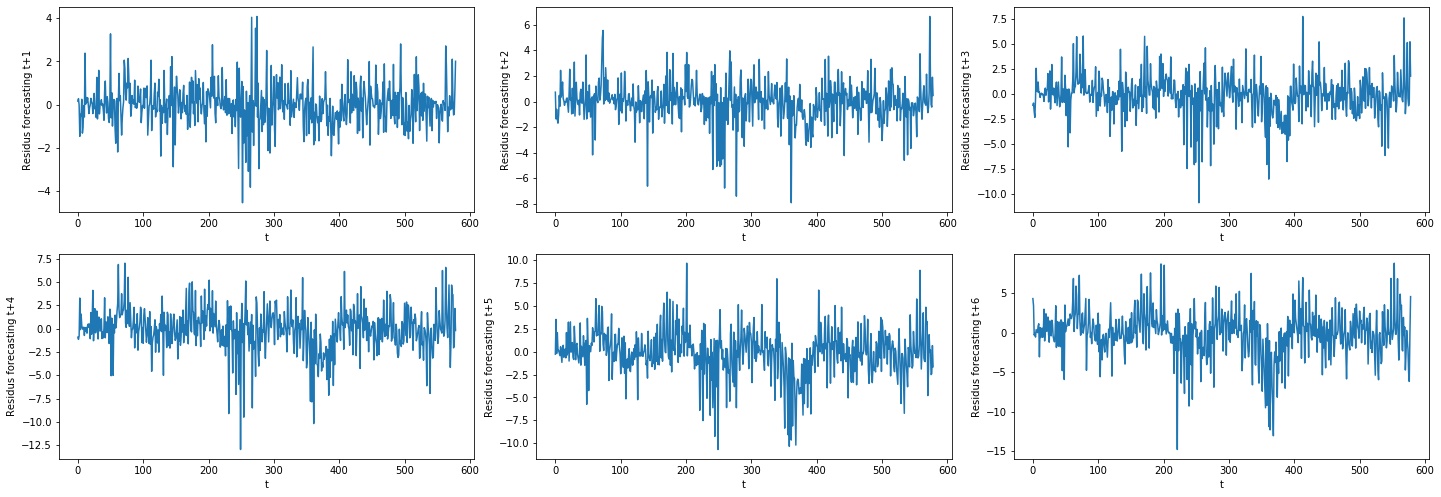

In [65]:
predict_train_rf = regressor_rf.predict(X_train)
residus_rf = (y_train - predict_train_rf)

t = [i for i in range(0,len(residus_rf['DO_t+1']))]
#print(t)
plt.subplots(figsize=(20,10))
plt.subplot(3, 3, 1)
plt.plot(t, residus_rf['DO_t+1']) 
plt.ylabel('Residus forecasting t+1')
plt.xlabel('t')
plt.subplot(3, 3, 2)
plt.plot(t, residus_rf['DO_t+2']) 
plt.ylabel('Residus forecasting t+2')
plt.xlabel('t')
plt.subplot(3, 3, 3)
plt.plot(t, residus_rf['DO_t+3']) 
plt.ylabel('Residus forecasting t+3')
plt.xlabel('t')
plt.subplot(3, 3, 4)
plt.plot(t, residus_rf['DO_t+4']) 
plt.ylabel('Residus forecasting t+4')
plt.xlabel('t')
plt.subplot(3, 3, 5)
plt.plot(t, residus_rf['DO_t+5']) 
plt.ylabel('Residus forecasting t+5')
plt.xlabel('t')
plt.subplot(3, 3, 6)
plt.plot(t, residus_rf['DO_t+6']) 
plt.ylabel('Residus forecasting t+6')
plt.xlabel('t')
plt.tight_layout()
plt.show()


## Conclusion et perspectives


La dernière méthode nous donne la meilleure prévision pour t+1. Cependant, pour les autres horizons de prévision, la régression linéaire l'emporte largement pour les devices 3, 4 et 5. Une première perspective en découle naturellement, il serait plus judicieux d'utiliser les forêts pour une prévision à t+1. Ensuite, considérer la régression linéaire pour les prévisions plus lointaine, en prenant en compte la prévision de la forêt (au moins pour les devices 3, 4 et 5). 

Nous avons également vu que quelque soit l'algorithme, les variables les plus souvent représentées comme importantes pour une prévision en t+k sont les trois valeurs de l'oxygène dissous en t+k-1, t+k-2 et t+k-3. Ceci peut sembler surprenant étant donné que l'on a 5 devices différents (dont les valeurs sont très différentes), que la température varie dans l'eau, comme à l'extérieur et que l'information horaire est donnée. Cependant en regardant l'évolution de l'oxygène dissous selon la température ou d'autres variables, les résultats des méthodes, il n'est pas clair de la relation entre ces variables. 

Toute l'analyse faite jusqu'ici était basée sur les variables données et les décalages temporelles pour notre variable d'intérêt. Une autre perspective serait de passer plus de temps sur le feature engineering, en cherchant peut-être des transformations ou combinaisons de variables qui auraient une relation plus claire avec l'oxygène dissous. Ci-dessous, quelques exemples où par exemple la température (weather et water) est multiplié par une puissance de l'heure et nous pouvons observer une légère amélioration de la relation avec l'oxygène dissous. 

In [66]:
#Tentative de transformation et de combinaison de variables
Data_DO_big['t_weather_temp'] = Data_DO_big['weather_temperature']*Data_DO_big['hour']*Data_DO_big['hour']*Data_DO_big['hour']
Data_DO_big['t_water_temp'] = Data_DO_big['WaterTemperature']*Data_DO_big['hour']*Data_DO_big['hour']
#Data_DO_big['t_humidity_temp'] = Data_DO_big['humidity']*Data_DO_big['hour']*Data_DO_big['hour']*Data_DO_big['hour']
#Data_DO_big['windspeed_weather'] = Data_DO_big['windspeed']*Data_DO_big['weather_temperature']
#Data_DO_big['windspeed_water'] = Data_DO_big['windspeed']*Data_DO_big['WaterTemperature']
#Data_DO_big['weather_water'] = Data_DO_big['weather_temperature']*Data_DO_big['WaterTemperature']
#Data_DO_big['windirection_water'] = Data_DO_big['winddirection']*Data_DO_big['WaterTemperature']
#Data_DO_big['windirection_weather'] = Data_DO_big['weather_temperature']*Data_DO_big['WaterTemperature']

In [67]:
mean_data_t_weather = Data_DO_big.groupby(['t_weather_temp', 'device']).mean()
mean_data_t_water = Data_DO_big.groupby(['t_water_temp', 'device']).mean()

Text(0.5, 0, 'Hour times Water Temp')

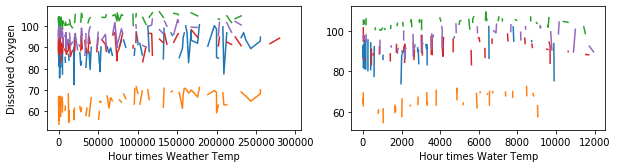

In [68]:
plt.subplots(figsize=(10,5))
plt.subplot(2, 2, 1)
plt.plot(mean_data_t_weather['DissolvedOxygen'].unstack()) 
plt.ylabel('Dissolved Oxygen')
plt.xlabel('Hour times Weather Temp')
plt.subplot(2, 2, 2)
plt.plot(mean_data_t_water['DissolvedOxygen'].unstack()) 
plt.xlabel('Hour times Water Temp')

Une troisième perspective serait d'utiliser une méthode permettant de donner de l'information en plus, typiquement comme les modèles GAM. Ces modèles rendent possible de préciser la forme des relations/fonctions selon les différentes variables, éventuellement les interactions entre elles et permettant également l'introduction de connaissances sur le domaine. Si on avait accès à plus d'observations, la voie du deep learning peut donner des performances bien plus excellentes (mais au prix d'une interprétation plus faible). Une dernière perspective serait de prendre un autre point de vue et de construire un modèle pour chaque heure (et éventuellement pour chaque device) au lieu de faire un modèle "global". Cela permettrait peut-être d'attraper certaines particularités locales qu'on ne pouvait pas jusqu'ici.